In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    import filterpy
    import geopy
except ImportError:
    !pip install filterpy
    !pip install geopy
from filterpy.kalman import KalmanFilter, EnsembleKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise, Saver
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.rcParams.update({'figure.max_open_warning': 0})

pd.set_option("display.max_columns", 500)

import warnings

warnings.filterwarnings("ignore")


     |################################| 184kB 6.5MB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110452 sha256=af8d6bcf89dd6f5ec525a45ec581cc65f6c01c14964df17feb3cce759691f1cc
  Stored in directory: /home/wsuser/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


### Reading Data

In [2]:
path = "https://raw.githubusercontent.com/rs-delve/covid19_datasets/master/dataset/combined_dataset_latest.csv"

stringency = pd.read_csv(path, parse_dates = ['DATE'])

stringency.head()

,ISO,DATE,country_name,npi_school_closing,npi_workplace_closing,npi_cancel_public_events,npi_gatherings_restrictions,npi_close_public_transport,npi_stay_at_home,npi_internal_movement_restrictions,npi_international_travel_controls,npi_income_support,npi_debt_relief,npi_fiscal_measures,npi_international_support,npi_public_information,npi_testing_policy,npi_contact_tracing,npi_healthcare_investment,npi_vaccine_investment,npi_stringency_index,npi_masks,cases_total,cases_new,deaths_total,deaths_new,cases_total_per_million,cases_new_per_million,deaths_total_per_million,deaths_new_per_million,tests_total,tests_new,tests_total_per_thousand,tests_new_per_thousand,tests_new_smoothed,tests_new_smoothed_per_thousand,stats_population,stats_population_density,stats_median_age,stats_gdp_per_capita,cases_days_since_first,deaths_days_since_first,iso_3166_2_code,census_fips_code,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,mobility_travel_driving,mobility_travel_transit,mobility_travel_walking,stats_hospital_beds_per_1000,stats_smoking,stats_population_urban,stats_population_school_age,deaths_excess_daily_avg,deaths_excess_weekly,weather_precipitation_mean,weather_humidity_mean,weather_sw_radiation_mean,weather_temperature_mean,weather_temperature_min,weather_temperature_max,weather_wind_speed_mean
0,ABW,2020-01-01,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,3.238519e-06,0.016900,220.264984,27.246809,26.732813,27.709375,9.019097
1,ABW,2020-01-02,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,6.755193e-07,0.016645,223.333893,27.049299,26.558985,27.508204,8.752604
2,ABW,2020-01-03,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,1.329184e-05,0.017244,220.742767,27.193014,26.695704,27.582422,8.564670
3,ABW,2020-01-04,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,1.788139e-07,0.016593,225.407074,27.267725,26.775782,27.771875,8.304688
4,ABW,2020-01-05,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,7.867813e-06,0.017142,219.864334,27.255766,26.965235,27.611719,5.604166


In [3]:
stringency[stringency['ISO']=='BEL']

,ISO,DATE,country_name,npi_school_closing,npi_workplace_closing,npi_cancel_public_events,npi_gatherings_restrictions,npi_close_public_transport,npi_stay_at_home,npi_internal_movement_restrictions,npi_international_travel_controls,npi_income_support,npi_debt_relief,npi_fiscal_measures,npi_international_support,npi_public_information,npi_testing_policy,npi_contact_tracing,npi_healthcare_investment,npi_vaccine_investment,npi_stringency_index,npi_masks,cases_total,cases_new,deaths_total,deaths_new,cases_total_per_million,cases_new_per_million,deaths_total_per_million,deaths_new_per_million,tests_total,tests_new,tests_total_per_thousand,tests_new_per_thousand,tests_new_smoothed,tests_new_smoothed_per_thousand,stats_population,stats_population_density,stats_median_age,stats_gdp_per_capita,cases_days_since_first,deaths_days_since_first,iso_3166_2_code,census_fips_code,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,mobility_travel_driving,mobility_travel_transit,mobility_travel_walking,stats_hospital_beds_per_1000,stats_smoking,stats_population_urban,stats_population_school_age,deaths_excess_daily_avg,deaths_excess_weekly,weather_precipitation_mean,weather_humidity_mean,weather_sw_radiation_mean,weather_temperature_mean,weather_temperature_min,weather_temperature_max,weather_wind_speed_mean
2024,BEL,2020-01-01,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11589616.0,375.564,41.8,42658.576,-34.0,-69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,28.2,3102595.0,1550783.0,-23.628571,NaN,2.953516e-07,0.004041,38.488944,1.936105,-0.084865,4.443646,2.704259
2025,BEL,2020-01-02,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11589616.0,375.564,41.8,42658.576,-33.0,-68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,28.2,3102595.0,1550783.0,-23.628571,NaN,2.111448e-06,0.004710,17.687699,3.924154,1.106208,7.465180,4.447062
2026,BEL,2020-01-03,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11589616.0,375.564,41.8,42658.576,-32.0,-67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,28.2,3102595.0,1550783.0,-23.628571,NaN,4.874654e-05,0.006116,13.096610,7.901739,5.249843,9.842861,6.270486
2027,BEL,2020-01-04,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11589616.0,375.564,41.8,42658.576,-31.0,-66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,28.2,3102595.0,1550783.0,-23.628571,NaN,3.227000e-06,0.004841,30.899286,5.135372,3.284922,6.987158,4.558841
2028,BEL,2020-01-05,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11589616.0,375.564,41.8,42658.576,-30.0,-65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,28.2,3102595.0,1550783.0,-23.628571,-165.4,1.885450e-06,0.004999,20.599938,5.640362,3.653823,7.129652,3.055893
2029,BEL,2020-01-06,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11589616.0,375.564,41.8,42658.576,-29.0,-64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,28.2,3102595.0,1550783.0,-7.371429,NaN,8.618761e-06,0.004428,44.755298,4.991296,3.418925,7.032064,4.348017
2030,BEL,2020-01-07,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11589616.0,375.564,41.8,42658.576,-28.0,-63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,28.2,3102595.0,1550783.0,-7.371429,NaN,5.799079e-06,0

### Test condition

In [132]:
# region name or None for country-level aggregation
region = None # 'Flanders', 'Brussels', 'Wallonia' or None
# date range to be used (must match with '%m-%d' format)
date_range = None
# date_range = ['03-15', '05-09'] # if date_range is None, use all dates
# interpolate cases and tests values during the weekends?
interpolate_weekend = False

### Load data

In [130]:
data_file = 'https://epistat.sciensano.be/Data/COVID19BE.xlsx'
#data_file = 'data/Belgium/COVID19BE.xlsx'
xls = pd.ExcelFile(data_file)
df_hosp = pd.read_excel(xls, 'HOSP')
df_hosp.columns = map(str.lower, df_hosp.columns)
if region:
    df_hosp = df_hosp[df_hosp.region == region]
df_hosp.date = pd.to_datetime(df_hosp.date, format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
df_hosp = df_hosp.sort_values('date').set_index('date')
df_hosp = df_hosp.groupby('date').sum()

In [131]:
df_hosp.head()

,nr_reporting,total_in,total_in_icu,total_in_resp,total_in_ecmo,new_in,new_out
date,,,,,,,
2020-03-15,104,266,54,32,1,71,18
2020-03-16,104,370,79,51,1,90,14
2020-03-17,105,497,100,66,3,122,31
2020-03-18,104,650,131,88,4,179,48
2020-03-19,106,844,165,115,4,207,49


### Select dates of interest

In [4]:
# default is without year. if year is required, make sure to modify accordingly.
if date_range:
    if date_range[0] is None:
        date_range[0] = '00-00'
    if date_range[1] is None:
        date_range[1] = '99-99'
    df_hosp = df_hosp[(df_hosp.index >= date_range[0]) & (df_hosp.index <= date_range[1])]

In [27]:
df_hosp.index.max()

'2020-06-26'

### Interpolate weekends if needed

In [4]:
def interpolate_weekend(x, col, first_friday):
    print('Interpolate for %s (Fri, Sat, Sun, Mon)' % col)
    first_friday_index = np.flatnonzero((x.index==first_friday))[0]
    for i in range(first_friday_index, x.shape[0]-3, 7):
        delta = (x.loc[x.index[i+3], col] - x.loc[x.index[i], col]) / 3
        value_sat = x.loc[x.index[i], col] + delta
        value_sun = value_sat + delta
#         print('[%s:%s] %7.1f, %7.1f > %-7.1f, %7.1f > %-7.1f, %7.1f' % (x.index[i], x.index[i+3],\
#             x.loc[x.index[i], col], x.loc[x.index[i+1], col], value_sat, x.loc[x.index[i+2], col], value_sun, x.loc[x.index[i+3], col]))
        x.loc[x.index[i+1], col] = value_sat
        x.loc[x.index[i+2], col] = value_sun
        return x

if interpolate_weekend is True:
    first_friday = '0320'
    interpolate_weekend(df_case, 'cases', first_friday)
    interpolate_weekend(df_case, 'vul_count', first_friday)
    interpolate_weekend(df_test, 'tests', first_friday)

    # recalculate vul_ratio after interpolation
    df_case['vul_ratio'] = df_case.vul_count / df_case.cases

### Kalman filter models

In [5]:
def kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_a):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)    
    - used params of kf_p=0, kf_r=10, kf_q=20
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, 0.5*(dt**2)], # x_new           = x_old + v*dt + 1/2*a*dt^2
                    [0, 1, dt],           # d(v_new) / dt   = v     + a*dt + 0
                    [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    '''
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # define a linear KF with position, velocity, acceleration parameters
    dim_x = F.shape[0]
    kf = KalmanFilter(dim_x=dim_x, dim_z=1)
    kf.F = F
    # state vector: initial position, velocity, acceleration
    kf.x = np.zeros(dim_x)
    kf.x[0] = initial_state
    # measuremnet matrix: can only directly measure case counts, not velocity & acceleration
    kf.H = np.zeros((1, dim_x))
    kf.H[0][0] = 1
    # covariance matrix
    kf.P *= kf_p
    # measurement noise
    kf.R = kf_r
    # process noise
    kf.Q = Q_discrete_white_noise(dim=dim_x, dt=1, var=kf_q)
    # fading factor
    kf.alpha = kf_a
    return kf

def ensemble_kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_n):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, (dt**2)/2], # x_new           = x_old + v*dt + 1/2*a*dt^2
                  [0, 1, dt],           # d(x_new) / dt   = v     + a*dt + 0
                  [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    ''' also consider jerk
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # state vector: initial position, velocity, acceleration
    X0 = np.zeros(F.shape[0])
    X0[0] = initial_state
    # transition function
    Fx = lambda x, dt: np.dot(F, x)
    # measuremnet function
    Hx = lambda x: np.array([x[0]])
    # covariance matrix
    P = np.eye(F.shape[0]) * kf_p
    # measurement noise
    R = kf_r
    # process noise
    Q = Q_discrete_white_noise(dim=F.shape[0], dt=1, var=kf_q)
    # let's make it
    kf = EnsembleKalmanFilter(x=X0, P=P, dim_z=1, dt=1, N=kf_n, hx=Hx, fx=Fx)
    kf.R = R
    kf.Q = Q
    return kf

### Forecast using Kalman filter

In [6]:
def kalman_forecast(series, days, kf_type, params):
    """
    Forecast based on history data.
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    days: Prediction window length
    kf_type: linear, unscented, ensemble
    kf_*: Parameters for Kalman filter. Default values work reasonably well on several countries.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    ci_*: Lower and upper bounds of CI
    """
    if days <= 0:
        raise ValueError
    dates = series.index
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError
    
    # fit model
    for measurement in series:
        kf.predict()
        kf.update([measurement])
    
    # start forecasting, starting from the last observation date
    
    if isinstance(dates[-1], str):
        
         last_date = dt.datetime.strptime(dates[-1], '%Y-%m-%d')
            
    else:
        
        last_date = dates[-1]
        
    predictions = []
    pred_acc = []
    pred_vel = []
    pred_dates = []
    ci_bounds = []
    for day in range(days):
        future_date = (last_date + dt.timedelta(days=day+1))
        pred_dates.append(future_date)
        kf.predict()
        predictions.append(kf.x[0])
        pred_acc.append(kf.x[2])
        pred_vel.append(kf.x[1])
        ci_bounds.append(kf_ci_bound(kf))
    
    # smoothen and add confidence intervals
    predictions = np.array(predictions)
    predictions[np.where(predictions < 0)[0]] = 0
    #smooth_buffer = list(series[dates[len(dates)-days+1:]])
    #predictions_smooth = smoother(smooth_buffer + predictions, days)[days-1:]
    predictions_smooth = smoother(predictions, days)
    ci_bounds = np.array(ci_bounds)
    ci_upper = predictions_smooth + ci_bounds
    ci_lower = predictions_smooth - ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    
    df_pred = pd.DataFrame({'pred_raw':predictions, 'pred':predictions_smooth, 'pred_vel': pred_vel, 
                          'pred_acc': pred_acc, 'ci_lower':ci_lower, 'ci_upper':ci_upper}, index=pred_dates)
    return df_pred

def kf_ci_bound(kf):
    """
    Compute 95% confidence interval from KF's positive semi-definite covariance matrix
    
    returns a positive single-sided boundary (half) of the interval
    -> CI = kf.x[0] +- kf_ci_bound(kf)
    """
    return 1.96 * (np.diag(kf.P)[0])**0.5

def smoother(x, winsize, method='slide'):
    if method == 'slide':
        x_smooth = []
        for i in range(len(x)):
            x_smooth.append(np.mean(x[max(0, i-winsize+1):i+1]))
    elif method == 'slide_recurse':
        x_smooth = predictions.copy()
        for i in range(len(x)):
            x_smooth[i] = np.mean(x_smooth[max(0, i-winsize):i+1])
    else:
        raise NotImplementedError
    assert(len(x) == len(x_smooth))
    return np.array(x_smooth)

### Helpers

In [7]:
def get_stats(observations, predictions):
    r2 = r2_score(observations, predictions)
    mae = mean_absolute_error(observations, predictions)
    rmse = mean_squared_error(observations, predictions) ** 0.5
    return r2, mae, rmse

def rescale(df_x):
    x = df_x.copy()
    x -= x.min()
    x /= x.max()
    return x

### Performance testing and debugging

In [8]:
def kalman_test(series, winsize, kf_type, params=None):
    """
    To test the performance compared with true values along all data points
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    winsize: Prediction window size in number of days.
    kf_type: linear, unscented, ensemble
    kf_*: factors for Kalman filter. Default values work reasonably well.
          For long-term prediction, usually increasing the fading factor (kf_a) helps.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    obs: Ground-truth values
    history: recursive prediction history at each time point (for debugging purpose)
    """
    if winsize <= 0:
        raise ValueError
    observations = []
    predictions = []
    predictions_acc = []
    predictions_vel = []
    pred_dates = []
    history = []
    ci_bounds = []
    dates = series.index.to_numpy()
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError(kf_type)
    
    for i in range(dates.shape[0]-winsize):
        # save the current state of the model
        saver = Saver(kf, skip_callable=True, save_current=True)
        
        # recursive prediction
        history_window = [kf.x[0]]
        date_window = [dates[i]]
        for day in range(winsize):
            kf.predict()
            history_window.append(kf.x[0])
            date_window.append(dates[i+day+1])
        history.append(pd.DataFrame({'pred':history_window}, index=date_window))
        pred_date = dates[i+winsize]
        pred_dates.append(pred_date)
        prediction = kf.x[0]
        predictions.append(prediction)
        predictions_vel.append(kf.x[1])
        predictions_acc.append(kf.x[2])
        observation = series[pred_date]
        observations.append(observation)
        ci_bounds.append(kf_ci_bound(kf))
        
        # restore model states and update to next day
        for attr in saver.keys:
            try:
                setattr(kf, attr, getattr(saver, attr)[-1])
            except AttributeError: # property decoration causes problem
                #print('.%s skip' % attr)
                continue
        kf.predict() ## is this predict call necessary at all?
        kf.update([series[dates[i+1]]])
    
    # smoothen output
    predictions_smooth = smoother(predictions, winsize)
    predictions_smooth[predictions_smooth < 0] = 0
    #acc_smooth = smoother(predictions_acc, winsize)
    #vel_smooth = smoother(predictions_vel, winsize)
    acc_smooth = predictions_acc
    vel_smooth = predictions_vel
    ci_bounds = np.array(ci_bounds)
    ci_lower = predictions_smooth - ci_bounds
    ci_upper = predictions_smooth + ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    df_pred = pd.DataFrame({'pred_raw':predictions[winsize:], 'pred':predictions_smooth[winsize:],
                          'obs':observations[winsize:], 'history':history[winsize:],
                          'ci_lower':ci_lower[winsize:], 'ci_upper':ci_upper[winsize:],
                          'pred_acc':acc_smooth[winsize:], 'pred_vel':vel_smooth[winsize:]},
                           index=pred_dates[winsize:])
    return df_pred

### Predict + plot functions

In [9]:
def test_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.
    
    """
    PLOT_RAW = True
    SHOW_TRAJECTORY = True
    DO_FORECAST = True
    
    result = kalman_test(series, winsize, kf_type, params)
    
    if DO_FORECAST:
        forecast = kalman_forecast(series, winsize, kf_type, params)
    
    r2, mae, rmse = get_stats(result.obs, result.pred)
    #r2, mae, rmse = get_stats(result.obs, result.pred_raw)
    
    plt.figure(figsize=[13,4])
    plt.plot(series.index, series, 'o', color='g', linewidth=3)
    plt.plot(result.index, result.pred, '-', color=(1,0,0,0.8), linewidth=3)
    if PLOT_RAW:
        plt.plot(result.index, result.pred_raw, 'o', color=(1,0,0,0.1), linewidth=3)
        if DO_FORECAST:
            plt.plot(forecast.index, forecast.pred_raw, 'o', color=(1,0,0,0.1), linewidth=3)
    plt.fill_between(result.index, result.ci_lower, result.ci_upper, color=(1,0,0,0.1))
    if DO_FORECAST:
        plt.plot(forecast.index, forecast.pred, color='r', linewidth=3)
        plt.fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if SHOW_TRAJECTORY:
        for df_h in result.history:
            plt.plot(df_h.index, df_h.pred, '-', color=(0,0,1,0.2))
    if y_lims:
        plt.ylim(y_lims)
    plt.xticks(rotation=45, fontsize='small')
    plt.title(r'%s ($r^2$:%.3f, mae:%d, rmse:%d=%.1f%% of global max %d)' % (title, r2, mae, rmse, rmse * 100 / series.max(), series.max()))
    plt.legend(['True', 'Prediction'])
    plt.grid(True, 'both')
    plt.tight_layout()
    
    plt.figure(figsize=[13,2])
    plt.plot(series.index, [0] * len(series.index), 'k')
    if DO_FORECAST:    
        plt.plot(forecast.index, [0]*len(forecast.index), 'k')
    plt.plot(result.index, result.pred_vel, '-', color=(0,0,1,0.8), linewidth=3)
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.grid(True, 'both')
    plt.title('Estimated growth rate')
    plt.tight_layout()
    
    plt.figure(figsize=[13,2])
    plt.plot(series.index, [0]*len(series.index), 'k')
    if DO_FORECAST:
        plt.plot(forecast.index, [0]*len(forecast.index), 'k')
    plt.plot(result.index, result.pred_acc, '-', color=(0,0,1,0.8), linewidth=3)
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.grid(True, 'both')
    plt.title('Estimated growth acceleration')
    plt.tight_layout()


In [10]:
def forecast_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.    
    """
    PLOT_RAW = True
    
    forecast = kalman_forecast(series, winsize, kf_type, params)
    plt.figure(figsize=[13,5])
    plt.plot(series.index, series, 'o', color='g', linewidth=3)
    plt.plot(forecast.index, forecast.pred, '-', color=(1,0,0,0.9), linewidth=3)
    if PLOT_RAW:
        plt.plot(forecast.index, forecast.pred_raw, '.', color='r')
    plt.fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if y_lims:
        plt.ylim(y_lims)
    plt.xticks(rotation=45, fontsize='small')
    plt.title(title)
    plt.legend(['True', 'Prediction'])
    plt.grid(True, 'both')
    plt.tight_layout()

### ICU prediction up to several days in the future

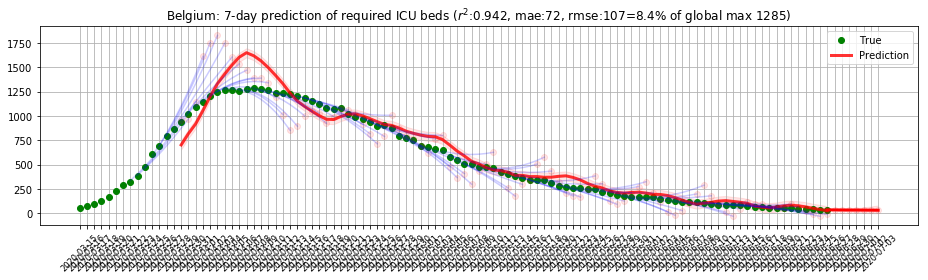

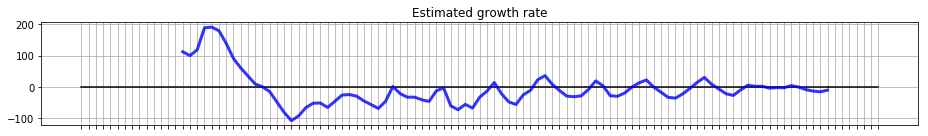

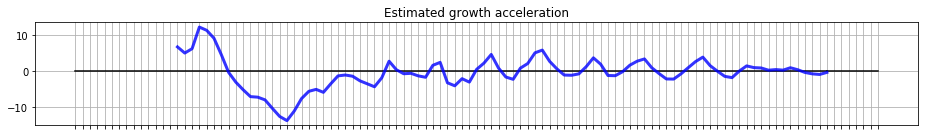

In [30]:
target = 'total_in_icu'
#kf_type = 'linear'
#kf_params = {'kf_p':1, 'kf_r':4, 'kf_q':0.10, 'kf_a':1}
kf_type = 'ensemble'
kf_params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_n':1000}
winsizes = [7]
show_trajectory = False
for winsize in winsizes:
    title = 'Belgium: %d-day prediction of required ICU beds' % winsize
    test_plot(df_hosp[target], winsize, kf_type, kf_params, title)

In [100]:
stringency.head()

,ISO,DATE,country_name,npi_school_closing,npi_workplace_closing,npi_cancel_public_events,npi_gatherings_restrictions,npi_close_public_transport,npi_stay_at_home,npi_internal_movement_restrictions,npi_international_travel_controls,npi_income_support,npi_debt_relief,npi_fiscal_measures,npi_international_support,npi_public_information,npi_testing_policy,npi_contact_tracing,npi_healthcare_investment,npi_vaccine_investment,npi_stringency_index,npi_masks,cases_total,cases_new,deaths_total,deaths_new,cases_total_per_million,cases_new_per_million,deaths_total_per_million,deaths_new_per_million,tests_total,tests_new,tests_total_per_thousand,tests_new_per_thousand,tests_new_smoothed,tests_new_smoothed_per_thousand,stats_population,stats_population_density,stats_median_age,stats_gdp_per_capita,cases_days_since_first,deaths_days_since_first,iso_3166_2_code,census_fips_code,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,mobility_travel_driving,mobility_travel_transit,mobility_travel_walking,stats_hospital_beds_per_1000,stats_smoking,stats_population_urban,stats_population_school_age,deaths_excess_daily_avg,deaths_excess_weekly,weather_precipitation_mean,weather_humidity_mean,weather_sw_radiation_mean,weather_temperature_mean,weather_temperature_min,weather_temperature_max,weather_wind_speed_mean
0,ABW,2020-01-01,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,3.238519e-06,0.016900,220.264984,27.246809,26.732813,27.709375,9.019097
1,ABW,2020-01-02,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,6.755193e-07,0.016645,223.333893,27.049299,26.558985,27.508204,8.752604
2,ABW,2020-01-03,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,1.329184e-05,0.017244,220.742767,27.193014,26.695704,27.582422,8.564670
3,ABW,2020-01-04,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,1.788139e-07,0.016593,225.407074,27.267725,26.775782,27.771875,8.304688
4,ABW,2020-01-05,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17521.0,NaN,NaN,7.867813e-06,0.017142,219.864334,27.255766,26.965235,27.611719,5.604166


### Predicted Cases up to several days in the future

In [231]:
## TODO: Write a wrapper function for the final Dataframe generation. Imprtant for WW Dataset Generation ...

In [107]:
target = 'cases_total'

winsize = 6

In [136]:
belgium_cases = stringency[stringency['ISO']=='BEL'][['DATE', 'country_name', 'ISO', 'cases_new']]

belgium_cases.set_index('DATE', inplace = True)

belgium_cases.head()

,country_name,ISO,cases_new
DATE,,,
2020-01-01,Belgium,BEL,0.0
2020-01-02,Belgium,BEL,0.0
2020-01-03,Belgium,BEL,0.0
2020-01-04,Belgium,BEL,0.0
2020-01-05,Belgium,BEL,0.0


In [144]:
# plt.rcParams["figure.figsize"] = (10,6)

# belgium_cases = interpolate_weekend(belgium_cases, 'cases_new', '2020-01-03')

# plt.plot(belgium_cases['cases_new']) 

In [445]:
belgium_new_cases_preds = kalman_forecast(belgium_cases[target], winsize, 'ensemble', None)

belgium_new_cases_preds

,pred_raw,pred,preds_vel,preds_acc,ci_lower,ci_upper
2020-06-28,33.707302,33.707302,-6.984318,-0.392014,0.0,80.352115
2020-06-29,26.534935,30.121119,-7.360417,-0.376100,0.0,87.911626
2020-06-30,18.984658,26.408965,-7.740136,-0.379718,0.0,97.342570
2020-07-01,11.060266,22.571790,-8.108649,-0.368513,0.0,108.656762
2020-07-02,2.767800,18.610992,-8.476283,-0.367634,0.0,121.869174
2020-07-03,0.000000,15.509160,-8.842227,-0.365944,0.0,138.004084


In [202]:
belgium_new_cases_test = kalman_test(belgium_cases[target], winsize, 'ensemble')

belgium_new_cases_test.tail()

,pred_raw,pred,obs,history,ci_lower,ci_upper,pred_acc,pred_vel
2020-06-23,77.540068,62.529315,112.0,pred 2020-06-17 85.914162 20...,0.0,184.965934,0.155149,-0.938754
2020-06-24,113.736891,58.975763,90.0,pred 2020-06-18 97.959552 ...,0.0,177.770465,0.448225,3.972041
2020-06-25,123.844382,64.416937,13.0,pred 2020-06-19 101.569710 ...,0.0,183.486203,0.510298,5.224935
2020-06-26,103.590140,75.690296,93.0,pred 2020-06-20 94.200477 ...,0.0,193.633372,0.323109,2.514728
2020-06-27,60.276866,90.037718,0.0,pred 2020-06-21 77.912974 20...,0.0,209.339354,-0.054500,-3.129458


In [216]:
belgium_new_cases_preds = pd.concat([belgium_new_cases_test, belgium_new_cases_preds])

belgium_new_cases_preds.iloc[:,-20:]

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,ci_lower,ci_upper,history,obs,pred,pred_acc,pred_raw,pred_vel
2020-01-13,0.000000,292.252584,pred 2020-01-07 0.622723 2020...,0.000000,1.670710,0.024577,2.058783,0.302783
2020-01-14,0.000000,260.623505,pred 2020-01-08 -0.147500 2020...,0.000000,0.365572,-0.052405,-2.198184,-0.504034
2020-01-15,0.000000,231.044872,pred 2020-01-09 -0.515827 2020...,0.000000,0.000000,-0.108332,-3.783201,-0.822477
2020-01-16,0.000000,210.969833,pred 2020-01-10 -0.178209 2020...,0.000000,0.000000,-0.074796,-2.335815,-0.589521
2020-01-17,0.000000,192.773205,pred 2020-01-11 0.250259 2020...,0.000000,0.000000,0.011082,0.234846,-0.004391
2020-01-18,0.000000,179.165426,pred 2020-01-12 0.295387 2020...,0.000000,0.000000,-0.031057,-0.196397,-0.178643
2020-01-19,0.000000,166.472616,pred 2020-01-13 0.045064 2020...,0.000000,0.000000,0.049146,0.098833,0.114049
2020-01-20,0.000000,150.583601,pred 2020-01-14 -0.207946 2020...,0.000000,0.000000,-0.002319,-1.428661,-0.248738
2020-01-21,0.000000,140.289402,pred 2020-01-15 0.524191 2020...,0.000000,0.000000,0.015282,0.772678,0.053739
2020-01-22,0.000000,130.750625,pred 2020-01-16 0.090580 2020...,0.000000,0.000000,-0.018230,-0.348854,-0.091509


In [345]:
belgium_cases.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-27'],
              dtype='datetime64[ns]', name='DATE', length=179, freq=None)

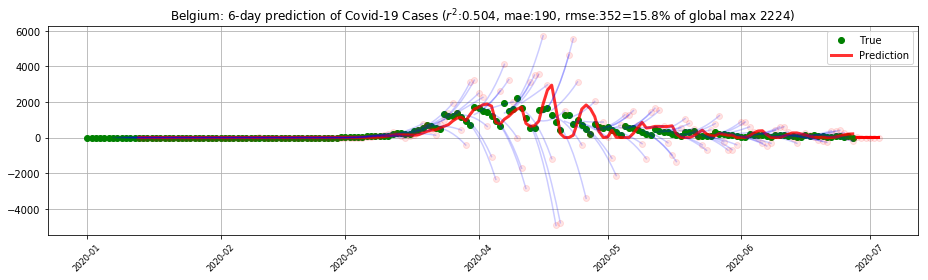

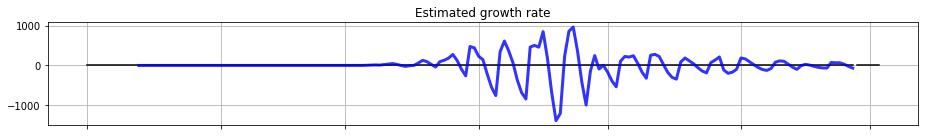

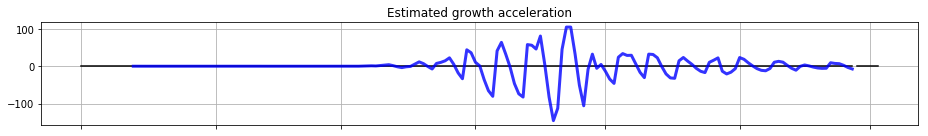

In [446]:
kf_type = 'ensemble'
kf_params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_n':1000}
winsizes = [6]
show_trajectory = True
for winsize in winsizes:
    title = 'Belgium: %d-day prediction of Covid-19 Cases' % winsize
    test_plot(belgium_cases[target], winsize, kf_type, kf_params, title)

In [162]:
belgium_df = belgium_new_cases_preds[['pred', 'ci_lower', 'ci_upper', 'pred_acc', 'pred_vel']]

belgium_df['country'] = 'belgium'

belgium_df.reset_index(inplace = True)

belgium_df.rename(columns = {'index' : 'DATE'}, inplace=True)

belgium_df['DATE'] = pd.to_datetime(belgium_df['DATE'], format ="%Y-%m-%d")

belgium_df.head()

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country
0,2020-01-13,10.465266,0.0,308.628264,0.248347,2.099828,belgium
1,2020-01-14,10.580609,0.0,267.809704,0.206358,2.176310,belgium
2,2020-01-15,10.280533,0.0,239.467743,0.196123,2.190859,belgium
3,2020-01-16,9.860841,0.0,219.039777,0.196295,1.788679,belgium
4,2020-01-17,9.435265,0.0,199.715535,0.129689,1.557881,belgium


In [220]:
stringency_belgium = stringency[['DATE', 'ISO', 'npi_stringency_index', 'tests_new_per_thousand', 'stats_population_density' , 'stats_population_urban',  'country_name']]

stringency_belgium = stringency_belgium[stringency_belgium['ISO']=='BEL'].drop_duplicates()

stringency_belgium.head()

,DATE,ISO,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,country_name
1969,2020-01-01,BEL,0.0,NaN,375.564,3081719.0,Belgium
1970,2020-01-02,BEL,0.0,NaN,375.564,3081719.0,Belgium
1971,2020-01-03,BEL,0.0,NaN,375.564,3081719.0,Belgium
1972,2020-01-04,BEL,0.0,NaN,375.564,3081719.0,Belgium
1973,2020-01-05,BEL,0.0,NaN,375.564,3081719.0,Belgium


In [221]:
belgium_risk_df.shape

(174, 14)

In [222]:
belgium_risk_df = belgium_df.merge(stringency_belgium, left_on = 'DATE' , right_on = 'DATE', how = 'left')

# assert belgium_risk_df.shape[0] == belgium_df.shape[0]

belgium_risk_df.head()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,ISO,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,country_name
0,2020-01-13,10.465266,0.0,308.628264,0.248347,2.099828,belgium,BEL,0.0,NaN,375.564,3081719.0,Belgium
1,2020-01-14,10.580609,0.0,267.809704,0.206358,2.176310,belgium,BEL,0.0,NaN,375.564,3081719.0,Belgium
2,2020-01-15,10.280533,0.0,239.467743,0.196123,2.190859,belgium,BEL,0.0,NaN,375.564,3081719.0,Belgium
3,2020-01-16,9.860841,0.0,219.039777,0.196295,1.788679,belgium,BEL,0.0,NaN,375.564,3081719.0,Belgium
4,2020-01-17,9.435265,0.0,199.715535,0.129689,1.557881,belgium,BEL,0.0,NaN,375.564,3081719.0,Belgium


In [223]:
belgium_risk_df

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,ISO,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,country_name
0,2020-01-13,10.465266,0.000000,308.628264,0.248347,2.099828,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
1,2020-01-14,10.580609,0.000000,267.809704,0.206358,2.176310,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
2,2020-01-15,10.280533,0.000000,239.467743,0.196123,2.190859,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
3,2020-01-16,9.860841,0.000000,219.039777,0.196295,1.788679,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
4,2020-01-17,9.435265,0.000000,199.715535,0.129689,1.557881,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
5,2020-01-18,8.632067,0.000000,179.573585,0.084598,1.076090,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
6,2020-01-19,8.190013,0.000000,165.015723,0.077868,1.049718,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
7,2020-01-20,7.162252,0.000000,158.278657,0.081475,0.734874,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
8,2020-01-21,5.546178,0.000000,143.085004,0.030061,0.310241,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium
9,2020-01-22,4.428496,0.000000,134.450452,0.005549,0.234407,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium


In [225]:
belgium_risk_df['npi_stringency_index'].fillna(method='ffill', inplace = True)

belgium_risk_df['infections_var'] = belgium_risk_df['pred'].diff()

In [226]:
belgium_risk_df

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,ISO,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,country_name,infections_var
0,2020-01-13,10.465266,0.000000,308.628264,0.248347,2.099828,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,NaN
1,2020-01-14,10.580609,0.000000,267.809704,0.206358,2.176310,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,0.115343
2,2020-01-15,10.280533,0.000000,239.467743,0.196123,2.190859,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.300076
3,2020-01-16,9.860841,0.000000,219.039777,0.196295,1.788679,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.419692
4,2020-01-17,9.435265,0.000000,199.715535,0.129689,1.557881,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.425576
5,2020-01-18,8.632067,0.000000,179.573585,0.084598,1.076090,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.803198
6,2020-01-19,8.190013,0.000000,165.015723,0.077868,1.049718,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.442054
7,2020-01-20,7.162252,0.000000,158.278657,0.081475,0.734874,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-1.027762
8,2020-01-21,5.546178,0.000000,143.085004,0.030061,0.310241,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-1.616074
9,2020-01-22,4.428496,0.000000,134.450452,0.005549,0.234407,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-1.117682


In [228]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode("Belgium")
belgium_risk_df['latitude'] = location.latitude
belgium_risk_df['longitude'] = location.longitude

belgium_risk_df

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,ISO,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,country_name,infections_var,risk_index,latitude,longitude
0,2020-01-13,10.465266,0.000000,308.628264,0.248347,2.099828,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,NaN,NaN,50.640281,4.666715
1,2020-01-14,10.580609,0.000000,267.809704,0.206358,2.176310,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,0.115343,0.069206,50.640281,4.666715
2,2020-01-15,10.280533,0.000000,239.467743,0.196123,2.190859,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.300076,-0.180046,50.640281,4.666715
3,2020-01-16,9.860841,0.000000,219.039777,0.196295,1.788679,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.419692,-0.251815,50.640281,4.666715
4,2020-01-17,9.435265,0.000000,199.715535,0.129689,1.557881,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.425576,-0.255346,50.640281,4.666715
5,2020-01-18,8.632067,0.000000,179.573585,0.084598,1.076090,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.803198,-0.481919,50.640281,4.666715
6,2020-01-19,8.190013,0.000000,165.015723,0.077868,1.049718,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-0.442054,-0.265232,50.640281,4.666715
7,2020-01-20,7.162252,0.000000,158.278657,0.081475,0.734874,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-1.027762,-0.616657,50.640281,4.666715
8,2020-01-21,5.546178,0.000000,143.085004,0.030061,0.310241,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-1.616074,-0.969644,50.640281,4.666715
9,2020-01-22,4.428496,0.000000,134.450452,0.005549,0.234407,belgium,BEL,0.00,NaN,375.564,3081719.0,Belgium,-1.117682,-0.670609,50.640281,4.666715


In [897]:
# from math import exp

# def risk_index(cases_acceleration, npi_stringency_index, **kwargs):
    
#     raw_index =  (0.6 * cases_acceleration - 0.4 * (npi_stringency_index/100))
    
#     return 1 / (1 + exp(-raw_index))

# ## The lower the stringency idenx --> Higher risk 
# ## Mobility Data ? 


# def discrete_risk_idx(risk_index):
    
#     if risk_index < 0.3:
        
#         return "low risk"
    
#     elif risk_index < 0.5:
            
#             return 'moderate risk'
    
#     else:
        
#         return "high risk"

# def generate_predictions(iso_country, target, winsize):
    
#     '''
    
#     '''
    
#     print("Processing {} Data".format(iso_country))
    
#     print("="*50)

    
#     ## Extract Target Data from Main Dataframe
    
#     columns = ['DATE', 'country_name', 'ISO'] + [target]
    
#     filtered_data  = stringency[stringency['ISO']==iso_country][columns]
    
#     filtered_data.set_index('DATE', inplace = True)
    
#     ## Train KF and Predict History , Predict Future
    
#     print("Training KF and Predicting {}, {} days ahead".format(target, winsize))
    
#     print("-"*32)
    
#     predict_hist = kalman_test(filtered_data[target], winsize, 'ensemble')
    
#     predict_future = kalman_forecast(filtered_data[target], winsize, 'ensemble', None)

#     kf_predictions_all = pd.concat([predict_hist, predict_future])
    
#     kf_predictions_all = kf_predictions_all[['pred', 'ci_lower', 'ci_upper', 'pred_acc', 'pred_vel']]

#     kf_predictions_all['country'] = iso_country

#     kf_predictions_all.reset_index(inplace = True)

#     kf_predictions_all.rename(columns = {'index' : 'DATE'}, inplace=True)

#     kf_predictions_all['DATE'] = pd.to_datetime(kf_predictions_all['DATE'], format ="%Y-%m-%d")

#     print("Reading and merging with Stringency and Complementary Data")
    
#     print("-"*32)
    
#     stringency_data = stringency[stringency['ISO']==iso_country].drop_duplicates()
    
#     stringency_data = stringency_data[['DATE', 'npi_stringency_index', 'tests_new_per_thousand', 'stats_population_density' , 'stats_population_urban',  'stats_population']]

#     stringency_merged_df  = kf_predictions_all.merge(stringency_data, left_on = 'DATE' , right_on = 'DATE', how = 'left')

#     print("Extrapolating Stringency Indices and Static Data")
    
#     print("-"*32)

#     # assert belgium_risk_df.shape[0] == belgium_df.shape[0]
    
#     stringency_merged_df['npi_stringency_index'].fillna(method='ffill', inplace = True)
    
#     stringency_merged_df['stats_population_density'].fillna(method='ffill', inplace = True)
    
#     stringency_merged_df['stats_population_urban'].fillna(method='ffill', inplace = True)
    
#     stringency_merged_df['stats_population'].fillna(method='ffill', inplace = True)

#     stringency_merged_df['infections_var'] = stringency_merged_df['pred'].pct_change()
    
#     print("Calculating the Risk Index")
    
#     print("-"*32)

#     stringency_merged_df['risk_index'] = stringency_merged_df[['infections_var', 'npi_stringency_index']].apply(lambda x: risk_index(x[0], x[1]), axis =1)
    
#     stringency_merged_df['risk_index_disc'] = stringency_merged_df['risk_index'].apply(lambda x: discrete_risk_idx(x))

#     print("Adding Geolocation Data")
    
#     print("-"*32)

#     geolocator = Nominatim(user_agent = "my_geocoder")
    
#     location = geolocator.geocode(iso_country)
    
#     stringency_merged_df['latitude'] = location.latitude
    
#     stringency_merged_df['longitude'] = location.longitude
    
#     return stringency_merged_df


In [293]:
france_df = generate_predictions('FRA', 'cases_total', 6)

belgium_df = generate_predictions('BEL', 'cases_total', 6)

germany_df = generate_predictions('DEU', 'cases_total', 6)

england_df = generate_predictions('GBR', 'cases_total', 6)

spain_df = generate_predictions('ESP', 'cases_total', 6)

italy_df = generate_predictions('ITA', 'cases_total', 6)

morocco_df = generate_predictions('MAR', 'cases_total', 6)


Processing FRA Data
Training KF and Predicting cases_total, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Processing BEL Data
Training KF and Predicting cases_total, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Processing DEU Data
Training KF and Predicting cases_total, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Extrapol

In [295]:
france_df.tail()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,infections_var,risk_index,risk_index_disc,latitude,longitude
168,2020-06-29,163051.071720,162993.749811,163108.393629,NaN,NaN,FRA,65.74,NaN,122.578,15244343.0,65273512.0,0.001346,0.434835,moderate risk,50.022944,8.524938
169,2020-06-30,163270.350179,163200.202267,163340.498091,NaN,NaN,FRA,65.74,NaN,122.578,15244343.0,65273512.0,0.001345,0.434835,moderate risk,50.022944,8.524938
170,2020-07-01,163489.816433,163404.990175,163574.642691,NaN,NaN,FRA,65.74,NaN,122.578,15244343.0,65273512.0,0.001344,0.434834,moderate risk,50.022944,8.524938
171,2020-07-02,163709.472324,163608.086138,163810.858511,NaN,NaN,FRA,65.74,NaN,122.578,15244343.0,65273512.0,0.001344,0.434834,moderate risk,50.022944,8.524938
172,2020-07-03,163929.319547,163809.449063,164049.190031,NaN,NaN,FRA,65.74,NaN,122.578,15244343.0,65273512.0,0.001343,0.434834,moderate risk,50.022944,8.524938


In [272]:
belgium_df.head()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,infections_var,risk_index,latitude,longitude
0,2020-01-13,0.000000,0.0,295.896042,0.227625,2.196646,BEL,0.0,NaN,375.564,3081719.0,11589616.0,NaN,NaN,40.005774,-81.009752
1,2020-01-14,0.925700,0.0,261.930335,0.205201,2.261129,BEL,0.0,NaN,375.564,3081719.0,11589616.0,inf,inf,40.005774,-81.009752
2,2020-01-15,2.927222,0.0,231.384047,0.122641,1.276150,BEL,0.0,NaN,375.564,3081719.0,11589616.0,2.162170,1.297302,40.005774,-81.009752
3,2020-01-16,4.939505,0.0,212.963362,0.049765,0.694797,BEL,0.0,NaN,375.564,3081719.0,11589616.0,0.687438,0.412463,40.005774,-81.009752
4,2020-01-17,5.997054,0.0,192.588080,0.050245,0.451421,BEL,0.0,NaN,375.564,3081719.0,11589616.0,0.214100,0.128460,40.005774,-81.009752


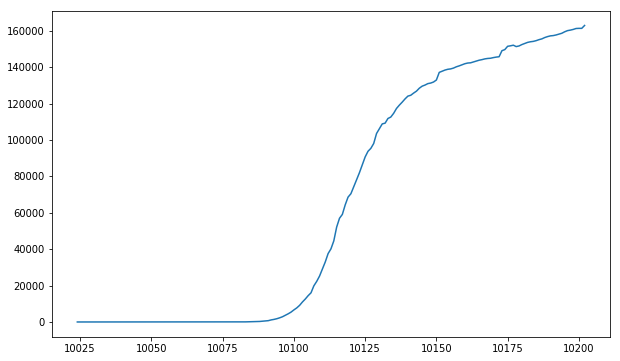

In [273]:
plt.plot(stringency[stringency['ISO']=='FRA']['cases_total'])

In [291]:
df_all = pd.concat([france_df, belgium_df, germany_df, england_df, spain_df, italy_df, morocco_df])

df_all.head()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,infections_var,risk_index,latitude,longitude
0,2020-01-13,0.0,0.0,295.345904,-0.058774,-0.405837,FRA,0.0,NaN,122.578,15244343.0,65273512.0,NaN,NaN,50.022944,8.524938
1,2020-01-14,0.0,0.0,262.669857,-0.167796,-1.746038,FRA,0.0,NaN,122.578,15244343.0,65273512.0,NaN,NaN,50.022944,8.524938
2,2020-01-15,0.0,0.0,234.069929,-0.116056,-1.150832,FRA,0.0,NaN,122.578,15244343.0,65273512.0,NaN,NaN,50.022944,8.524938
3,2020-01-16,0.0,0.0,208.598844,-0.009099,-0.135367,FRA,0.0,NaN,122.578,15244343.0,65273512.0,NaN,NaN,50.022944,8.524938
4,2020-01-17,0.0,0.0,192.907705,0.063075,0.436365,FRA,0.0,NaN,122.578,15244343.0,65273512.0,NaN,NaN,50.022944,8.524938


In [290]:
df_all[(df_all['country'] == 'GBR')]

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,infections_var,risk_index,latitude,longitude
0,2020-01-13,6.133113,0.000000,323.049435,0.026424,0.545109,GBR,0.00,NaN,272.898,17831615.0,67886004.0,NaN,NaN,53.317942,-60.46425
1,2020-01-14,5.935587,0.000000,272.516495,0.143335,1.391526,GBR,0.00,NaN,272.898,17831615.0,67886004.0,-0.032206,0.495169,53.317942,-60.46425
2,2020-01-15,6.017044,0.000000,245.709640,0.151862,1.708036,GBR,0.00,NaN,272.898,17831615.0,67886004.0,0.013723,0.502059,53.317942,-60.46425
3,2020-01-16,5.304064,0.000000,219.381099,0.054358,0.605221,GBR,0.00,NaN,272.898,17831615.0,67886004.0,-0.118493,0.482233,53.317942,-60.46425
4,2020-01-17,3.737265,0.000000,205.208867,-0.053196,-0.454320,GBR,0.00,NaN,272.898,17831615.0,67886004.0,-0.295396,0.455806,53.317942,-60.46425
5,2020-01-18,2.970898,0.000000,179.010599,-0.087126,-0.734404,GBR,0.00,NaN,272.898,17831615.0,67886004.0,-0.205061,0.469280,53.317942,-60.46425
6,2020-01-19,2.008140,0.000000,166.989698,-0.079448,-0.662430,GBR,0.00,NaN,272.898,17831615.0,67886004.0,-0.324063,0.451543,53.317942,-60.46425
7,2020-01-20,0.241614,0.000000,150.161608,-0.049839,-0.602695,GBR,0.00,NaN,272.898,17831615.0,67886004.0,-0.879683,0.371028,53.317942,-60.46425
8,2020-01-21,0.000000,0.000000,143.790883,-0.043308,-0.492290,GBR,0.00,NaN,272.898,17831615.0,67886004.0,-1.000000,0.354344,53.317942,-60.46425
9,2020-01-22,0.000000,0.000000,137.232271,-0.073259,-0.486372,GBR,0.00,NaN,272.898,17831615.0,67886004.0,NaN,NaN,53.317942,-60.46425


In [234]:
france_cases = stringency[stringency['ISO']=='FRA'][['DATE', 'country_name', 'ISO', 'cases_new']]

france_cases.set_index('DATE', inplace = True)

france_cases.head()

,country_name,ISO,cases_new
DATE,,,
2020-01-01,France,FRA,0.0
2020-01-02,France,FRA,0.0
2020-01-03,France,FRA,0.0
2020-01-04,France,FRA,0.0
2020-01-05,France,FRA,0.0


In [235]:
france_new_cases_preds = kalman_forecast(france_cases[target], winsize, 'ensemble', None)

france_new_cases_preds

,pred_raw,pred,ci_lower,ci_upper
2020-06-28,711.263555,711.263555,666.599275,755.927835
2020-06-29,776.556806,743.910181,688.524204,799.296157
2020-06-30,848.372112,778.730825,710.635363,846.826286
2020-07-01,926.696814,815.722322,732.934874,898.509770
2020-07-02,1011.535057,854.884869,755.429984,954.339754
2020-07-03,1102.900855,896.220867,778.093278,1014.348456


In [237]:
france_new_cases_test = kalman_test(france_cases[target], winsize, 'ensemble')

france_new_cases_test.tail()

,pred_raw,pred,obs,history,ci_lower,ci_upper,pred_acc,pred_vel
2020-06-23,138.407699,214.091734,373.0,pred 2020-06-17 311.113735 ...,95.532405,332.651062,-0.854425,-31.355083
2020-06-24,273.496757,268.523152,517.0,pred 2020-06-18 344.228011 ...,148.724496,388.321807,0.677308,-9.752474
2020-06-25,396.733497,284.693927,81.0,pred 2020-06-19 379.116005 ...,167.207318,402.180536,1.848453,8.476317
2020-06-26,813.231684,353.764455,0.0,pred 2020-06-20 525.057010 ...,235.967609,471.561301,5.459211,64.452616
2020-06-27,958.082263,451.319418,1588.0,pred 2020-06-21 587.821022 ...,334.241827,568.397008,6.205130,80.278136


### Analyzing UK Data at the ULTA level

In [11]:
## Reading UK Regional and LTLA Reported Cases

uk_regional_data = pd.read_csv('/project_data/data_asset/coronavirus-cases_latest_uk_utla.csv')

uk_regional_data['Specimen date'] = pd.to_datetime(uk_regional_data['Specimen date'], format = "%d/%m/%Y")

uk_regional_data.sort_values('Specimen date', ascending = True, inplace = True)

uk_regional_data.set_index('Specimen date', inplace = True)

uk_regional_data.head()


,Area name,Area code,Area type,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases,Cumulative lab-confirmed cases rate
Specimen date,,,,,,,,,,
2020-01-30,York,E06000014,Lower tier local authority,1.0,NaN,NaN,1,NaN,NaN,0.5
2020-01-30,England,E92000001,Nation,2.0,2.0,0.0,2,2.0,0.0,0.0
2020-01-30,York,E06000014,Upper tier local authority,1.0,NaN,NaN,1,NaN,NaN,0.5
2020-01-30,Yorkshire and The Humber,E12000003,Region,1.0,NaN,NaN,1,NaN,NaN,0.0
2020-02-03,England,E92000001,Nation,6.0,6.0,0.0,8,8.0,0.0,0.0


In [12]:
uk_regional_data[uk_regional_data['Area type']=='Nation']['Area name'].unique()

array(['England'], dtype=object)

In [37]:
uk_country = uk_regional_data[uk_regional_data['Area type']=='Nation']
uk_country = uk_country[uk_country.index >= '2020-02-22']
uk_country.tail(10)

,Area name,Area code,Area type,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases,Cumulative lab-confirmed cases rate
Specimen date,,,,,,,,,,
2020-06-20,England,E92000001,Nation,150.0,151.0,-1.0,159367,159360.0,7.0,284.7
2020-06-21,England,E92000001,Nation,119.0,121.0,-2.0,159486,159481.0,5.0,284.9
2020-06-22,England,E92000001,Nation,201.0,202.0,-1.0,159687,159683.0,4.0,285.3
2020-06-23,England,E92000001,Nation,204.0,202.0,2.0,159891,159885.0,6.0,285.6
2020-06-24,England,E92000001,Nation,168.0,164.0,4.0,160059,160049.0,10.0,285.9
2020-06-25,England,E92000001,Nation,150.0,134.0,16.0,160209,160183.0,26.0,286.2
2020-06-26,England,E92000001,Nation,116.0,92.0,24.0,160325,160275.0,50.0,286.4
2020-06-27,England,E92000001,Nation,57.0,17.0,40.0,160382,160292.0,90.0,286.5
2020-06-28,England,E92000001,Nation,9.0,0.0,9.0,160391,160292.0,99.0,286.5


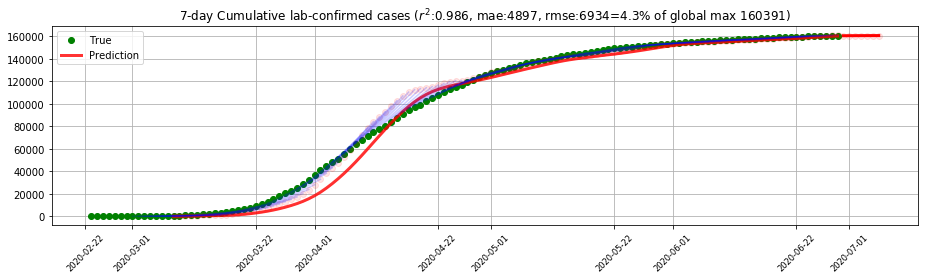

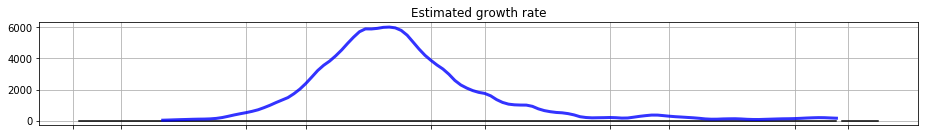

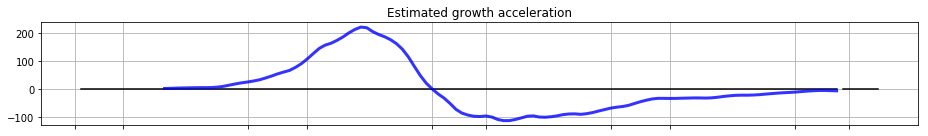

In [33]:
win_size = 7
key = 'Cumulative lab-confirmed cases'
series = uk_country[key]
kf_type = 'ensemble'
kf_params = {'kf_p':1, 'kf_r':100, 'kf_q':0.01, 'kf_n':1000}
test_plot(series, win_size, kf_type, kf_params, '%d-day %s' % (win_size, key))


In [76]:
### Export results & SI to CSV

In [368]:
## Reading Regional and LTLA Population Stats Data

xls = pd.ExcelFile('/project_data/data_asset/ukmidyearestimates20192020ladcodes.xls')

pop_stats = pd.read_excel(xls, 'MYE2 - Persons', skiprows = 4)

pop_stats.head()

,Code,Name,Geography1,All ages,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90+
0,K02000001,UNITED KINGDOM,Country,66796807.0,722881.0,752554.0,777309.0,802334.0,802185.0,809152.0,827149.0,852059.0,838680.0,822812.0,813774.0,820269.0,793405.0,777849.0,748569.0,736855.0,717056.0,708482.0,733067.0,761508.0,797247.0,811223.0,842201.0,850411.0,851998.0,879406.0,882616.0,911206.0,928979.0,912042.0,903442.0,912000.0,889687.0,896728.0,895275.0,872653.0,879070.0,877449.0,883170.0,883325.0,848120.0,790679.0,778814.0,793909.0,808017.0,822075.0,858311.0,895065.0,924065.0,902606.0,924754.0,924666.0,936289.0,934335.0,940971.0,930783.0,909684.0,888131.0,856779.0,820531.0,801220.0,782729.0,752215.0,723647.0,695374.0,694374.0,682311.0,659691.0,661251.0,670572.0,683532.0,714929.0,768023.0,588245.0,564138.0,556173.0,511519.0,451509.0,400077.0,406018.0,393605.0,372612.0,344104.0,316201.0,288806.0,255542.0,230667.0,210077.0,186163.0,159641.0,605181.0
1,K03000001,GREAT BRITAIN,Country,64903140.0,700160.0,729146.0,753103.0,777260.0,777225.0,784154.0,801776.0,825785.0,812581.0,797010.0,787647.0,794127.0,768470.0,754088.0,725407.0,713972.0,694660.0,686098.0,710566.0,739275.0,774174.0,788433.0,819124.0,827256.0,828734.0,855780.0,858947.0,886375.0,903860.0,886962.0,878457.0,886649.0,864133.0,871106.0,870026.0,847655.0,854401.0,852853.0,857965.0,858210.0,823998.0,767670.0,755956.0,770974.0,784687.0,798092.0,833365.0,869781.0,898296.0,876808.0,898690.0,898167.0,909988.0,907991.0,914195.0,904528.0,884109.0,863181.0,832285.0,797151.0,778569.0,760463.0,730946.0,703319.0,676084.0,675493.0,663890.0,642055.0,643742.0,653146.0,666359.0,697988.0,751228.0,572800.0,549093.0,541518.0,497605.0,439224.0,389239.0,395836.0,383494.0,363446.0,335419.0,308434.0,281696.0,249323.0,224878.0,205072.0,181788.0,156024.0,591447.0
2,K04000001,ENGLAND AND WALES,Country,59439840.0,649388.0,676412.0,698837.0,720721.0,719821.0,726317.0,742744.0,765225.0,750173.0,737531.0,726528.0,733267.0,709958.0,696722.0,668590.0,658280.0,640608.0,632385.0,653732.0,677608.0,708336.0,720698.0,748254.0,755826.0,757151.0,782598.0,784090.0,807248.0,824760.0,810973.0,802809.0,810906.0,790832.0,798415.0,797946.0,777820.0,783817.0,781425.0,787003.0,788497.0,756871.0,705441.0,694855.0,706616.0,720070.0,732367.0,763688.0,795939.0,821630.0,801260.0,820123.0,818248.0,829626.0,828203.0,831741.0,823099.0,802885.0,784119.0,755249.0,722779.0,705065.0,689075.0,661702.0,636452.0,612394.0,612894.0,602897.0,583460.0,585085.0,594546.0,606965.0,637206.0,686169.0,524406.0,503866.0,496130.0,455010.0,400818.0,354441.0,361072.0,350455.0,332255.0,306983.0,282197.0,257792.0,228197.0,206177.0,188071.0,167219.0,143992.0,547789.0
3,E92000001,ENGLAND,Country,56286961.0,618858.0,644056.0,665596.0,686135.0,684992.0,691122.0,706742.0,727938.0,712204.0,700200.0,689733.0,695753.0,673789.0,660928.0,634043.0,624590.0,607496.0,599393.0,618873.0,639880.0,668129.0,679576.0,706968.0,715442.0,717748.0,740656.0,742735.0,765411.0,782363.0,770244.0,762666.0,771667.0,752937.0,760681.0,760003.0,741443.0,746952.0,745065.0,749311.0,750871.0,721254.0,672514.0,661799.0,673246.0,685484.0,696569.0,725600.0,755206.0,778729.0,759708.0,776578.0,775173.0,785471.0,784074.0,786165.0,777616.0,758665.0,740085.0,712624.0,681661.0,664457.0,649021.0,622905.0,599252.0,576200.0,575744.0,566050.0,547827.0,549233.0,557886.0,569617.0,598038.0,645078.0,493261.0,473332.0,466239.0,427207.0,375723.0,332047.0,339470.0,329713.0,312737.0,289092.0,265631.0,242740.0,214727.0,194007.0,177399.0,157770.0,135875.0,517273.0
4,E12000001,NORTH EAST,Region,2669941.0,26621.0,27612.0,28621.0,29575.0,29315.0,30224.0,30960.0,31956.0,32027.0,31543.0,30703.0,31194.0,30129.0,30285.0,28445.0,28077.0,27511.0,27259.0,28888.0,33611.0,36055.0,36399.0,35413.0,34700.0,34123.0,35082.0,35

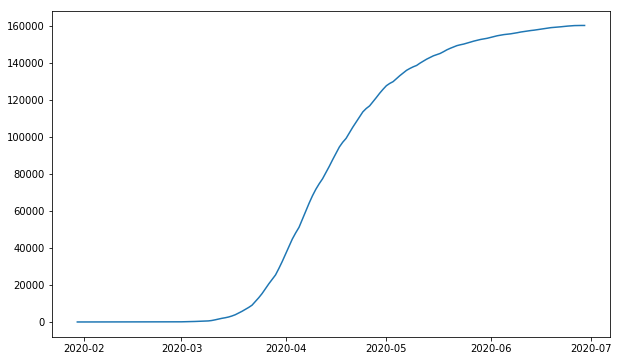

In [331]:
plt.plot(uk_regional_data[uk_regional_data['Area name']=='England']['Cumulative lab-confirmed cases'])



In [66]:
stringency[stringency['ISO']=='GBR'].tail()

,ISO,DATE,country_name,npi_school_closing,npi_workplace_closing,npi_cancel_public_events,npi_gatherings_restrictions,npi_close_public_transport,npi_stay_at_home,npi_internal_movement_restrictions,npi_international_travel_controls,npi_income_support,npi_debt_relief,npi_fiscal_measures,npi_international_support,npi_public_information,npi_testing_policy,npi_contact_tracing,npi_healthcare_investment,npi_vaccine_investment,npi_stringency_index,npi_masks,cases_total,cases_new,deaths_total,deaths_new,cases_total_per_million,cases_new_per_million,deaths_total_per_million,deaths_new_per_million,tests_total,tests_new,tests_total_per_thousand,tests_new_per_thousand,tests_new_smoothed,tests_new_smoothed_per_thousand,stats_population,stats_population_density,stats_median_age,stats_gdp_per_capita,cases_days_since_first,deaths_days_since_first,iso_3166_2_code,census_fips_code,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,mobility_travel_driving,mobility_travel_transit,mobility_travel_walking,stats_hospital_beds_per_1000,stats_smoking,stats_population_urban,stats_population_school_age,deaths_excess_daily_avg,deaths_excess_weekly,weather_precipitation_mean,weather_humidity_mean,weather_sw_radiation_mean,weather_temperature_mean,weather_temperature_min,weather_temperature_max,weather_wind_speed_mean
10851,GBR,2020-06-28,United Kingdom,3.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,71.3,2.0,310250.0,890.0,43514.0,100.0,4570.161,13.110,640.986,1.473,4852547.0,54311.0,71.481,0.800,71735.0,1.057,67886004.0,272.898,40.8,39753.244,149.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.75,41.11,61.46,2.8,22.3,18018197.0,8474410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10852,GBR,2020-06-29,United Kingdom,3.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,71.3,2.0,311151.0,901.0,43550.0,36.0,4583.434,13.272,641.517,0.530,4905196.0,50414.0,72.256,0.743,71684.0,1.056,67886004.0,272.898,40.8,39753.244,150.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.41,44.37,68.47,2.8,22.3,18018197.0,8474410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10853,GBR,2020-06-30,United Kingdom,3.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,71.3,2.0,311965.0,814.0,43575.0,25.0,4595.424,11.991,641.885,0.368,4998914.0,93855.0,73.637,1.383,76793.0,1.131,67886004.0,272.898,40.8,39753.244,151.0,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.88,43.94,72.47,2.8,22.3,18018197.0,8474410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10854,GBR,2020-07-01,United Kingdom,3.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,71.3,2.0,312654.0,689.0,43730.0,155.0,4605.574,10.149,644.168,2.283,NaN,NaN,NaN,NaN,NaN,NaN,67886004.0,272.898,40.8,39753.244,152.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,22.3,18018197.0,8474410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10855,GBR,2020-07-02,United Kingdom,3.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,71.3,2.0,313483.0,829.0,43906.0,176.0,4617.785,12.212,646.761,2.593,NaN,NaN,NaN,NaN,NaN,NaN,67886004.0,272.898,40.8,39753.244,153.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,22.3,18018197.0,8474410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [783]:
# risk_index(-5.587238, 0.6, 0.09)

0.5 * -5.587238  + 0.2 * (0.6/100) - 0.3 * (77/100)

-3.023419

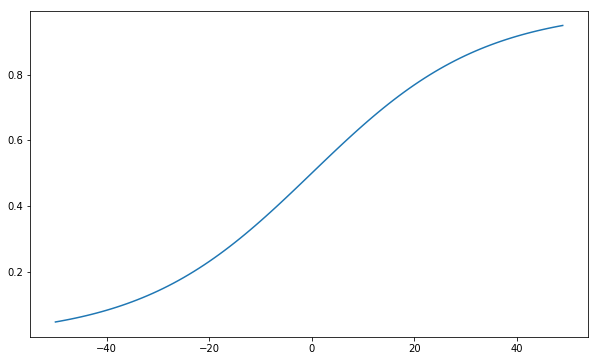

In [895]:
x = np.arange(-50, 50)

sig = []

for ii in x:
    
    sig.append(1/(1 + exp(-0.06 * ii)))

plt.plot(x, sig)

## Function to be used for Predictions and Risk Index Calculation

In [899]:
from math import exp

def risk_index(growth_rate, npi_stringency_index, population_density, **kwargs):
    
    raw_index =  (0.5 * growth_rate  + 0.2 * (population_density/100) - 0.3 * (npi_stringency_index/100))
    
    raw_index = 100 * 1 / (1 + exp(-0.1 * raw_index))
        
    return raw_index


def discrete_risk_idx(risk_index):
    
    if risk_index < 20:
        
        return "0 - 20"
    
    elif risk_index < 50:
            
        return "20 - 50"
    
    elif risk_index < 70:
            
        return "50 - 70"
        
    elif risk_index < 90:
            
        return "70 - 90"
        
    else:
        
        return "90 - 100"
    
## stringency + mobility --> population's behaviour 
## WS2 --> regional's mood and awarness could be an input 


def generate_predictions_granular(df, target, winsize, country_name, country_iso_code, area_type, area_name):
    
    '''
    
    '''
    
    print("Predicting {} Days ahead".format(winsize))
    
    print("="*50)
    
    columns = ['Area name', 'Area type', 'Area code'] + [target]
    
    series = df[(df['Area name'] == area_name) & (df['Area type'] == area_type)][columns]
    
    print("Series Shape: {}".format(series.shape))
    
    if len(series) > 0 :
        
       ## Train KF and Predict History , Predict Future

        print("Training KF and Predicting {}, {} days ahead".format(target, winsize))

        print("-"*32)

        predict_hist = kalman_test(series[target], winsize, 'ensemble')

        predict_future = kalman_forecast(series[target], winsize, 'ensemble', None)

        kf_predictions_all = pd.concat([predict_hist, predict_future])

        kf_predictions_all = kf_predictions_all[['pred', 'ci_lower', 'ci_upper', 'pred_acc', 'pred_vel']]
        
        kf_predictions_all['country'] = country_name

        kf_predictions_all['area_name'] = series['Area name'][0]

        kf_predictions_all['area_type'] = series['Area type'][0]

        kf_predictions_all.reset_index(inplace = True)

        kf_predictions_all.rename(columns = {'index' : 'DATE'}, inplace=True)

        kf_predictions_all['DATE'] = pd.to_datetime(kf_predictions_all['DATE'], format ="%Y-%m-%d")

        print("Reading and merging with Stringency and Complementary Data")

        print("-"*32)

        stringency_data = stringency[stringency['ISO']==country_iso_code].drop_duplicates()

        stringency_data = stringency_data[['DATE', 'npi_stringency_index', 'tests_new_per_thousand', 'stats_population_density' , 'stats_population_urban',  'stats_population', 

                                           'mobility_retail_recreation', 'mobility_grocery_pharmacy', 'mobility_parks', 'mobility_transit_stations', 'mobility_workplaces']]

        stringency_merged_df  = kf_predictions_all.merge(stringency_data, left_on = 'DATE' , right_on = 'DATE', how = 'left')

        print("Merging with Regional Population Data")

        print("-"*32)

        area_code = series[series['Area name'] == area_name]['Area code'][0]
        
        if len(pop_stats[pop_stats['Code']==area_code]) > 0:
            
            stringency_merged_df['area_population_density'] = int(pop_stats[pop_stats['Code']==area_code]['All ages'])*100.00/int(pop_stats[pop_stats['Name'] == country_name]['All ages'])

        else:
            
            stringency_merged_df['area_population_density'] = 0       
           
        print("Extrapolating Stringency Indices and Static Data")

        print("-"*32)

        # assert belgium_risk_df.shape[0] == belgium_df.shape[0]

        stringency_merged_df['npi_stringency_index'].fillna(method='ffill', inplace = True)

        stringency_merged_df['stats_population_density'].fillna(method='ffill', inplace = True)

        stringency_merged_df['stats_population_urban'].fillna(method='ffill', inplace = True)

        stringency_merged_df['stats_population'].fillna(method='ffill', inplace = True)

        stringency_merged_df['area_population_density'].fillna(method = 'ffill', inplace = True)

    #     stringency_merged_df['infections_var'] = stringency_merged_df['pred'].pct_change()

        print("Calculating the Risk Index")

        print("-"*32)

        stringency_merged_df['risk_index'] = stringency_merged_df[['pred_vel', 'npi_stringency_index', 'area_population_density']].apply(lambda x: risk_index(x[0], x[1], x[2]), axis =1)

        stringency_merged_df['risk_index_disc'] = stringency_merged_df['risk_index'].apply(lambda x: discrete_risk_idx(x))

        print("Adding Geolocation Data")

        print("-"*32)

        geolocator = Nominatim(user_agent = "my_geocoder")

        location = geolocator.geocode(area_name)

        stringency_merged_df['latitude'] = location.latitude

        stringency_merged_df['longitude'] = location.longitude

        return stringency_merged_df


In [632]:
# columns = ['Area name', 'Area type', 'Area code'] + ['Cumulative lab-confirmed cases']

# series = series[series['Area type']!='Lower tier local authority']

# series = uk_regional_data[uk_regional_data['Area name']=='Kent'][columns]

# dates = series.index

# series['Cumulative lab-confirmed cases'][dates[0]]


# generate_predictions_granular(uk_regional_data, 'Cumulative lab-confirmed cases', 6, 'ENGLAND', 'GBR', 'Buckinghamshire')

In [594]:
# (series.reset_index().groupby(['Specimen date', 'Area name', 'Area type', 'Area code'], as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-2]])
#    .reset_index(level=0, drop=True))

In [764]:
df = uk_regional_data[uk_regional_data['Area type'] == 'Region']

columns = ['Area name', 'Area type', 'Area code'] + ['Cumulative lab-confirmed cases']

series = df[(df['Area name'] == 'South West') & (df['Area type'] == 'Region')][columns]

series

# series = df[(df['Area name'] == area_name) & (df['Area type'] == area_type)][columns]

,Area name,Area type,Area code,Cumulative lab-confirmed cases
Specimen date,,,,
2020-02-03,South West,Region,E12000009,2
2020-02-26,South West,Region,E12000009,3
2020-03-01,South West,Region,E12000009,5
2020-03-02,South West,Region,E12000009,13
2020-03-03,South West,Region,E12000009,23
2020-03-04,South West,Region,E12000009,29
2020-03-05,South West,Region,E12000009,33
2020-03-06,South West,Region,E12000009,44
2020-03-07,South West,Region,E12000009,46


## Processing Risk Index for England

In [836]:
uk_regional_data['Area type'].unique()

array(['Lower tier local authority', 'Nation',
       'Upper tier local authority', 'Region'], dtype=object)

In [900]:
%%time


# area_types_uk = uk_regional_data['Area type'].unique()

area_types_uk = ['Nation', 'Region', 'Upper tier local authority']

all_areas_uk_risk_index = pd.DataFrame()

for area_type_i in area_types_uk: 
    
    uk_regional_data_i = uk_regional_data[uk_regional_data['Area type'] == area_type_i]
    
    geo_list = uk_regional_data_i['Area name'].unique()
    
    all_areas_names_uk = pd.DataFrame()
    
    for ii in geo_list:
        
        print("Generating risk index for: {} - {}".format(area_type_i, ii))

        kf_predictions_all = generate_predictions_granular(uk_regional_data_i, 'Cumulative lab-confirmed cases', 6, 'ENGLAND', 'GBR', area_type_i, ii)

        all_areas_names_uk = all_areas_names_uk.append(kf_predictions_all)
    
    all_areas_uk_risk_index = all_areas_uk_risk_index.append(all_areas_names_uk)

                
all_areas_uk_risk_index.head()


Generating risk index for: Nation - England
Predicting 6 Days ahead
Series Shape: (141, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Region - Yorkshire and The Humber
Predicting 6 Days ahead
Series Shape: (126, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
-----------------

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Hertfordshire
Predicting 6 Days ahead
Series Shape: (118, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority 

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Camden
Predicting 6 Days ahead
Series Shape: (89, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Milton

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Essex
Predicting 6 Days ahead
Series Shape: (114, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Hounsl

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Merton
Predicting 6 Days ahead
Series Shape: (82, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Bromle

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Hillingdon
Predicting 6 Days ahead
Series Shape: (92, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - St

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - North Yorkshire
Predicting 6 Days ahead
Series Shape: (104, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authorit

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Waltham Forest
Predicting 6 Days ahead
Series Shape: (80, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority 

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Derby
Predicting 6 Days ahead
Series Shape: (104, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Tamesi

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Bexley
Predicting 6 Days ahead
Series Shape: (93, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Portsm

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Central Bedfordshire
Predicting 6 Days ahead
Series Shape: (104, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local aut

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - St. Helens
Predicting 6 Days ahead
Series Shape: (80, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - Ga

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local authority - North East Lincolnshire
Predicting 6 Days ahead
Series Shape: (64, 4)
Training KF and Predicting Cumulative lab-confirmed cases, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Upper tier local a

In [901]:
all_areas_uk_risk_index.head()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,risk_index,risk_index_disc,latitude,longitude
0,2020-02-21,42.977050,0.0,345.730280,0.331448,5.363903,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,5.0,-1.0,10.0,-3.0,-15.0,100.0,57.073783,50 - 70,52.795479,-0.54024
1,2020-02-23,48.139664,0.0,307.719759,0.196085,4.329917,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,-1.0,-2.0,-5.0,3.0,-1.0,100.0,55.802806,50 - 70,52.795479,-0.54024
2,2020-02-24,48.747261,0.0,281.042132,0.059168,2.406793,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,-3.0,-1.0,-9.0,-2.0,-2.0,100.0,53.419818,50 - 70,52.795479,-0.54024
3,2020-02-25,43.565993,0.0,246.641714,-0.074462,1.251643,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,-1.0,4.0,3.0,1.0,1.0,100.0,51.980192,50 - 70,52.795479,-0.54024
4,2020-02-26,38.167354,0.0,220.883465,-0.066756,0.906198,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,1.0,0.0,6.0,-1.0,1.0,100.0,51.548926,50 - 70,52.795479,-0.54024


(array([9.000e+00, 3.000e+00, 0.000e+00, 1.470e+02, 2.435e+03, 5.172e+03,
        2.439e+03, 1.645e+03, 1.032e+03, 1.328e+03]),
 array([  0.1066911 ,  10.09602199,  20.08535288,  30.07468377,
         40.06401466,  50.05334555,  60.04267644,  70.03200733,
         80.02133822,  90.01066911, 100.        ]),
 <a list of 10 Patch objects>)

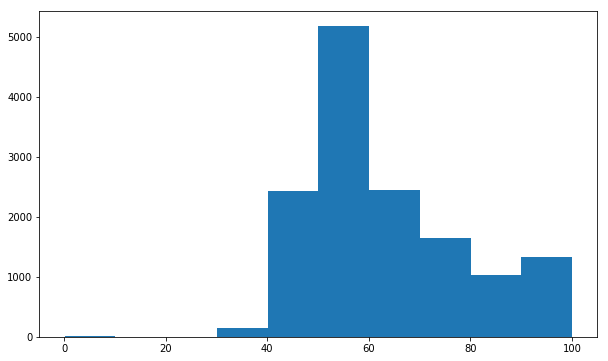

In [902]:
# length = np.arange(all_areas_uk_risk_index.shape[0])

plt.hist(all_areas_uk_risk_index[['risk_index']].to_numpy().flatten())

In [508]:
# !pip install folium 

# import folium

# regions = uk_regional_data['Area name'].unique()

# geo_loc = []

# for i in regions:
    
#     geolocator = Nominatim(user_agent = "my_geocoder")
    
#     location = geolocator.geocode(i)
    
#     geo_loc.append([location.latitude, location.longitude])
    

# map = folium.Map(location=[38.9, -77.05], zoom_start=12)

for point in range(0, len(geo_loc)):
    
    folium.Marker(geo_loc[point], popup = geo_loc[point]).add_to(map)

map

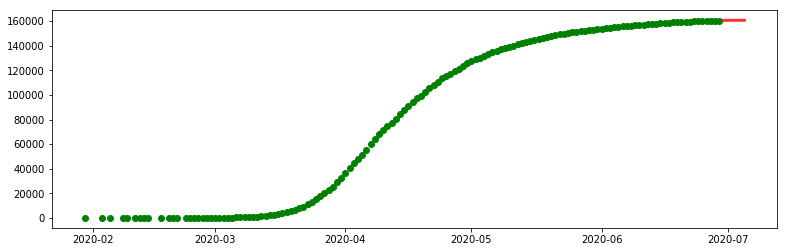

In [362]:
plt.figure(figsize=[13,4])
plt.plot(series.index, series['Cumulative lab-confirmed cases'], 'o', color='g', linewidth=3)
plt.plot(predictions.index, predictions.pred, '-', color=(1,0,0,0.8), linewidth=3)


### Processing France Data




In [903]:
codes_officiel_france = pd.read_csv('/project_data/data_asset/code-officiel-geographique-2019-regions-et-departement (1).csv', sep = ";")

codes_officiel_france.head()


,Code INSEE Département,Code INSEE Région,Code INSEE Chef Lieu Département,Nom Département majuscule,Nom Département,Libellé Département,Code INSEE Chef Lieu Région,Nom Région majuscule,Libellé Région,Nom région
0,10,44,10387,AUBE,Aube,Aube,67482,GRAND EST,Grand Est,Grand Est
1,64,75,64445,PYRENEES ATLANTIQUES,Pyrénées-Atlantiques,Pyrénées-Atlantiques,33063,NOUVELLE AQUITAINE,Nouvelle-Aquitaine,Nouvelle-Aquitaine
2,91,11,91228,ESSONNE,Essonne,Essonne,75056,ILE DE FRANCE,Île-de-France,Île-de-France
3,971,1,97105,GUADELOUPE,Guadeloupe,Guadeloupe,97105,GUADELOUPE,Guadeloupe,Guadeloupe
4,29,53,29232,FINISTERE,Finistère,Finistère,35238,BRETAGNE,Bretagne,Bretagne


In [904]:
fr_infections_regions = pd.read_csv('/project_data/data_asset/donnees-hospitalieres-classe-age-covid19-2020-06-30-19h00.csv', sep = ";")

fr_infections_regions_agg = fr_infections_regions[['reg', 'jour', 'hosp']].groupby(['reg', 'jour'])['hosp'].sum().reset_index()

fr_infections_regions_agg = fr_infections_regions_agg.merge(codes_officiel_france[['Code INSEE Région', 'Nom Région majuscule']], left_on = 'reg', right_on = 'Code INSEE Région')


In [905]:
fr_infections_regions_agg['Area type'] = 'Region'

In [906]:
fr_infections_regions_agg.rename(columns={'Nom Région majuscule': 'Area name', 'Code INSEE Région': 'Area code', 'jour': 'Specimen date'}, inplace = True)

fr_infections_regions_agg.drop('reg', inplace = True, axis =1 )

print("The dataset contains {} duplicates".format(fr_infections_regions_agg.duplicated().sum()))

fr_infections_regions_agg.drop_duplicates(inplace = True)

fr_infections_regions_agg.head()


The dataset contains 8632 duplicates


,Specimen date,hosp,Area code,Area name,Area type
0,2020-03-18,0,1,GUADELOUPE,Region
1,2020-03-19,0,1,GUADELOUPE,Region
2,2020-03-20,0,1,GUADELOUPE,Region
3,2020-03-21,0,1,GUADELOUPE,Region
4,2020-03-22,12,1,GUADELOUPE,Region


In [907]:
fr_infections_dep = pd.read_csv('/project_data/data_asset/donnees-hospitalieres-covid19-2020-06-30-19h00.csv', sep = ';')

fr_infections_dep_agg = fr_infections_dep[['dep', 'jour', 'hosp']].groupby(['dep', 'jour'])['hosp'].sum().reset_index()

fr_infections_dep_agg = fr_infections_dep_agg.merge(codes_officiel_france[['Code INSEE Département', 'Nom Département majuscule']], left_on = 'dep', right_on = 'Code INSEE Département')

fr_infections_dep_agg['Area type'] = 'Department'

print("The dataset contains {} duplicates".format(fr_infections_dep_agg.duplicated().sum()))

fr_infections_dep_agg.drop_duplicates(inplace = True)

fr_infections_dep_agg.head()


The dataset contains 0 duplicates


,dep,jour,hosp,Code INSEE Département,Nom Département majuscule,Area type
0,01,2020-03-18,4,01,AIN,Department
1,01,2020-03-19,4,01,AIN,Department
2,01,2020-03-20,4,01,AIN,Department
3,01,2020-03-21,8,01,AIN,Department
4,01,2020-03-22,16,01,AIN,Department


In [908]:
fr_infections_dep_agg.rename(columns={'Nom Département majuscule': 'Area name', 'Code INSEE Département': 'Area code', 'jour': 'Specimen date'}, inplace = True)

fr_infections_dep_agg.drop('dep', inplace = True, axis =1)

fr_infections_dep_agg.head()

,Specimen date,hosp,Area code,Area name,Area type
0,2020-03-18,4,01,AIN,Department
1,2020-03-19,4,01,AIN,Department
2,2020-03-20,4,01,AIN,Department
3,2020-03-21,8,01,AIN,Department
4,2020-03-22,16,01,AIN,Department


In [909]:
pd.to_datetime(fr_infections_agg.index)

DatetimeIndex(['2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-30', '2020-06-27',
               '2020-06-28', '2020-06-29'],
              dtype='datetime64[ns]', name='Specimen date', length=12477, freq=None)

In [910]:
fr_infections_agg = pd.concat([fr_infections_regions_agg, fr_infections_dep_agg], axis =0 )

fr_infections_agg.set_index('Specimen date', inplace=True)

fr_infections_agg.index = pd.to_datetime(fr_infections_agg.index)

fr_infections_agg.head()

,hosp,Area code,Area name,Area type
Specimen date,,,,
2020-03-18,0,1,GUADELOUPE,Region
2020-03-19,0,1,GUADELOUPE,Region
2020-03-20,0,1,GUADELOUPE,Region
2020-03-21,0,1,GUADELOUPE,Region
2020-03-22,12,1,GUADELOUPE,Region


In [865]:
fr_infections_agg[(fr_infections_agg['Area name']=='ILE DE FRANCE') & (fr_infections_agg['Area type']=='region') ]

,hosp,Area code,Area name,Area type
Specimen date,,,,
2020-03-18,1901,11,ILE DE FRANCE,region
2020-03-19,2925,11,ILE DE FRANCE,region
2020-03-20,3528,11,ILE DE FRANCE,region
2020-03-21,4312,11,ILE DE FRANCE,region
2020-03-22,5229,11,ILE DE FRANCE,region
2020-03-23,6239,11,ILE DE FRANCE,region
2020-03-24,7327,11,ILE DE FRANCE,region
2020-03-25,8730,11,ILE DE FRANCE,region
2020-03-26,10207,11,ILE DE FRANCE,region


In [875]:
fr_infections_agg.tail()

,hosp,Area code,Area name,Area type
Specimen date,,,,
2020-06-26,72,976,MAYOTTE,department
2020-06-30,70,976,MAYOTTE,department
2020-06-27,68,976,MAYOTTE,department
2020-06-28,68,976,MAYOTTE,department
2020-06-29,66,976,MAYOTTE,department


In [911]:
fr_all_areas_preds = pd.DataFrame()

area_types_all = fr_infections_agg['Area type'].unique()

for area_type in area_types_all:
    
    df_area_type = fr_infections_agg[fr_infections_agg['Area type'] == area_type]
    
    fr_area_preds = pd.DataFrame()
    
    area_names_all = df_area_type['Area name'].unique()
    
    for area_name in area_names_all:
        
        print("Generating risk index for: {} - {}".format(area_type, area_name))
        
        one_preds = generate_predictions_granular(fr_infections_agg, 'hosp', 6, 'FRANCE', 'FRA', area_type, area_name)
        
        fr_area_preds = fr_area_preds.append(one_preds)
    
    fr_all_areas_preds = fr_all_areas_preds.append(fr_area_preds)
        
fr_all_areas_preds.head()      

Generating risk index for: Region - GUADELOUPE
Predicting 6 Days ahead
Series Shape: (104, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Region - MARTINIQUE
Predicting 6 Days ahead
Series Shape: (104, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Region - AUVERGNE RHONE ALPES
Predicting 6 Days ahead
Series Shape: (104, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Region - PROVENCE ALPES COTE D AZUR
Predicting 6 Days ahead
Series

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - AVEYRON
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - BOUCHES DU RHONE
Predicting 6 Days ahead
Series Shape: (105, 4

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - EURE
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - EURE ET LOIR
Predicting 6 Days ahead
Series Shape: (105, 4)
Train

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - JURA
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - LANDES
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - MAYENNE
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - MEURTHE ET MOSELLE
Predicting 6 Days ahead
Series Shape: (105,

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - BAS RHIN
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - HAUT RHIN
Predicting 6 Days ahead
Series Shape: (105, 4)
Trai

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - TARN
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - TARN ET GARONNE
Predicting 6 Days ahead
Series Shape: (105, 4)
Tr

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - VAL D OISE
Predicting 6 Days ahead
Series Shape: (105, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Department - GUADELOUPE
Predicting 6 Days ahead
Series Shape: (105, 4)
T

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,risk_index,risk_index_disc,latitude,longitude
0,2020-03-30,28.084963,0.0,327.906818,0.811683,9.646301,FRANCE,GUADELOUPE,Region,90.74,NaN,122.578,15244343.0,65273512.0,-84.0,-47.0,-66.0,-83.0,-74.0,0,61.184947,50 - 70,16.249007,-61.565044
1,2020-03-31,36.990473,0.0,301.088356,0.472007,6.378184,FRANCE,GUADELOUPE,Region,90.74,NaN,122.578,15244343.0,65273512.0,-90.0,-38.0,-61.0,-82.0,-74.0,0,57.240913,50 - 70,16.249007,-61.565044
2,2020-04-01,55.675886,0.0,286.045670,1.192260,15.961062,FRANCE,GUADELOUPE,Region,90.74,NaN,122.578,15244343.0,65273512.0,-90.0,-39.0,-62.0,-81.0,-71.0,0,68.370065,50 - 70,16.249007,-61.565044
3,2020-04-02,80.732982,0.0,286.920221,1.581237,22.343194,FRANCE,GUADELOUPE,Region,90.74,NaN,122.578,15244343.0,65273512.0,-90.0,-36.0,-62.0,-82.0,-73.0,0,74.836999,70 - 90,16.249007,-61.565044
4,2020-04-03,108.427468,0.0,299.307698,2.114351,30.518271,FRANCE,GUADELOUPE,Region,90.74,NaN,122.578,15244343.0,65273512.0,-86.0,-38.0,-66.0,-82.0,-72.0,0,81.737925,70 - 90,16.249007,-61.565044


In [758]:
generate_predictions_granular(fr_infections_agg, 'hosp', 6, 'France', 'FRA', 'region', 'GUADELOUPE')

Predicting 6 Days ahead
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------


,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,risk_index,risk_index_disc,latitude,longitude
0,2020-03-30,29.409951,0.000000,335.181015,0.653354,8.203351,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-84.0,-47.0,-66.0,-83.0,-74.0,0,-2.910343,low risk,16.249007,-61.565044
1,2020-03-31,35.806146,0.000000,294.820182,0.445677,6.294254,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-90.0,-38.0,-61.0,-82.0,-74.0,0,NaN,high risk,16.249007,-61.565044
2,2020-04-01,51.823991,0.000000,282.787618,1.146927,15.067599,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-90.0,-39.0,-62.0,-81.0,-71.0,0,-1.199836,low risk,16.249007,-61.565044
3,2020-04-02,77.518942,0.000000,289.285225,1.668099,22.760722,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-90.0,-36.0,-62.0,-82.0,-73.0,0,-0.576557,low risk,16.249007,-61.565044
4,2020-04-03,106.950487,0.000000,299.923269,2.184685,31.694225,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-86.0,-38.0,-66.0,-82.0,-72.0,0,-0.198302,low risk,16.249007,-61.565044
5,2020-04-04,137.057888,0.000000,310.557463,2.039624,31.540674,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-88.0,-45.0,-73.0,-80.0,-57.0,0,-0.290898,low risk,16.249007,-61.565044
6,2020-04-05,164.390211,2.883431,325.896992,1.448843,24.822948,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-85.0,-62.0,-73.0,-82.0,-53.0,0,-0.793627,low risk,16.249007,-61.565044
7,2020-04-06,188.953516,40.496378,337.410655,1.003718,19.524134,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-83.0,-37.0,-61.0,-81.0,-72.0,0,-1.471246,low risk,16.249007,-61.565044
8,2020-04-07,199.633494,57.709564,341.557424,0.584186,13.964447,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-82.0,-35.0,-61.0,-80.0,-72.0,0,-3.918402,low risk,16.249007,-61.565044
9,2020-04-08,197.787477,62.889522,332.685431,0.228955,9.654353,GUADELOUPE,region,90.74,NaN,122.578,15244343.0,65273512.0,-84.0,-37.0,-63.0,-80.0,-70.0,0,NaN,high risk,16.249007,-61.565044


## Data For Italy


In [74]:
italy_data_national = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

italy_data_province = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')

italy_data_regional = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')

italy_data_national.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,NaN,NaN,229,4324,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,NaN,NaN,322,8623,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,NaN,NaN,400,9587,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,NaN,NaN,650,12014,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,NaN,NaN,888,15695,NaN,NaN


In [975]:
italy_data_regional[italy_data_regional['denominazione_regione']]

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,NaN,NaN,0,5,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,NaN,NaN
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,NaN,NaN,0,1,NaN,NaN
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,NaN,NaN,0,10,NaN,NaN
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,NaN,NaN,18,148,NaN,NaN


In [75]:
italy_data_province.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,NaN
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,NaN
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,NaN
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,NaN
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,NaN,NaN,0,NaN


In [945]:
italy_data_national_preds = italy_data_national[['data', 'stato', 'totale_positivi']]

italy_data_national_preds.rename(columns = {'data': 'Specimen date', 'totale_positivi': 'hosp'}, inplace = True)

italy_data_national_preds['Specimen date'] = pd.to_datetime(italy_data_national_preds['Specimen date'], format = "%Y-%m-%d")

italy_data_national_preds['Specimen date'] = italy_data_national_preds['Specimen date'].apply(lambda x : dt.datetime.strftime(x,  "%Y-%m-%d"))


In [948]:
italy_data_national_preds = italy_data_national[['data', 'stato', 'totale_positivi']]

italy_data_national_preds.rename(columns = {'data': 'Specimen date', 'totale_positivi': 'hosp'}, inplace = True)

italy_data_national_preds['Specimen date'] = pd.to_datetime(italy_data_national_preds['Specimen date'], format = "%Y-%m-%d")

italy_data_national_preds['Specimen date'] = italy_data_national_preds['Specimen date'].apply(lambda x : dt.datetime.strftime(x,  "%Y-%m-%d"))

italy_data_national_preds['Area code'] = None

italy_data_national_preds['Area name'] = 'ITALY'

italy_data_national_preds['Area type'] = 'Nation'

italy_data_national_preds.drop('stato', inplace = True, axis = 1)

italy_data_national_preds.set_index('Specimen date', inplace = True)


In [949]:
italy_data_national_preds.head()

,hosp,Area code,Area name,Area type
Specimen date,,,,
2020-02-24,221,None,ITALY,Nation
2020-02-25,311,None,ITALY,Nation
2020-02-26,385,None,ITALY,Nation
2020-02-27,588,None,ITALY,Nation
2020-02-28,821,None,ITALY,Nation


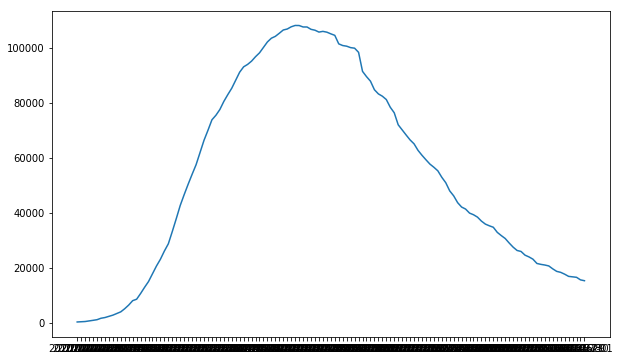

In [999]:
plt.plot(italy_data_national_preds['hosp'])

In [978]:
italy_data_regional_preds = italy_data_regional[['data', 'stato', 'denominazione_regione', 'codice_regione', 'totale_casi']]

italy_data_regional_preds.rename(columns = {'data': 'Specimen date', 'totale_casi': 'hosp', 'denominazione_regione': 'Area name', 'codice_regione': 'Area code'}, inplace = True)

italy_data_regional_preds['Specimen date'] = pd.to_datetime(italy_data_regional_preds['Specimen date'], format = "%Y-%m-%d")

italy_data_regional_preds['Specimen date'] = italy_data_regional_preds['Specimen date'].apply(lambda x : dt.datetime.strftime(x,  "%Y-%m-%d"))

italy_data_regional_preds['Area type'] = 'Region'

italy_data_regional_preds.drop('stato', inplace = True, axis = 1)

italy_data_regional_preds.set_index('Specimen date', inplace = True)

In [980]:
italy_data_regional_preds.head()

,Area name,Area code,hosp,Area type
Specimen date,,,,
2020-02-24,Abruzzo,13,0,Region
2020-02-24,Basilicata,17,0,Region
2020-02-24,Calabria,18,0,Region
2020-02-24,Campania,15,0,Region
2020-02-24,Emilia-Romagna,8,18,Region


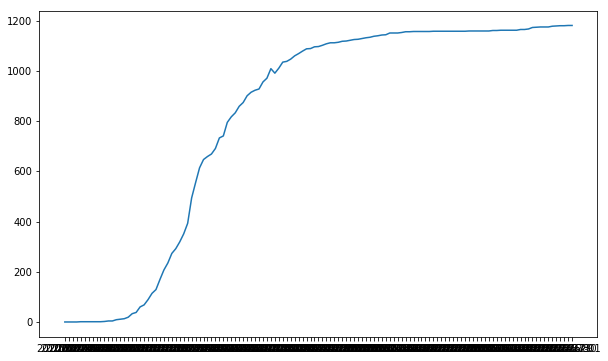

In [1002]:
plt.plot(italy_data_regional_preds[italy_data_regional_preds['Area name']=='Calabria']['hosp'])

In [992]:
italy_data_province.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,NaN
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,NaN
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,NaN
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,NaN
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,NaN,NaN,0,NaN


In [997]:
italy_data_province_preds = italy_data_province[['data', 'denominazione_provincia', 'totale_casi']].groupby(['data', 'denominazione_provincia'])['totale_casi'].sum().reset_index()

italy_data_province_preds.rename(columns = {'data': 'Specimen date', 'totale_casi': 'hosp', 'denominazione_provincia': 'Area name'}, inplace = True)

italy_data_province_preds['Specimen date'] = pd.to_datetime(italy_data_province_preds['Specimen date'], format = "%Y-%m-%d")

italy_data_province_preds['Specimen date'] = italy_data_province_preds['Specimen date'].apply(lambda x : dt.datetime.strftime(x,  "%Y-%m-%d"))

italy_data_province_preds['Area code'] = None

italy_data_province_preds['Area type'] = 'Province'

italy_data_province_preds.set_index('Specimen date', inplace = True)


In [998]:
italy_data_province_preds[italy_data_province_preds['Area name']=='In fase di definizione/aggiornamento']

,Area name,hosp,Area code,Area type
Specimen date,,,,
2020-02-24,In fase di definizione/aggiornamento,0,None,Province
2020-02-25,In fase di definizione/aggiornamento,10,None,Province
2020-02-26,In fase di definizione/aggiornamento,30,None,Province
2020-02-27,In fase di definizione/aggiornamento,25,None,Province
2020-02-28,In fase di definizione/aggiornamento,62,None,Province
2020-02-29,In fase di definizione/aggiornamento,71,None,Province
2020-03-01,In fase di definizione/aggiornamento,117,None,Province
2020-03-02,In fase di definizione/aggiornamento,188,None,Province
2020-03-03,In fase di definizione/aggiornamento,51,None,Province


In [982]:
italy_data_province.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,NaN
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,NaN
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,NaN
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,NaN
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,NaN,NaN,0,NaN


In [1023]:
italy_data_regional[italy_data_regional['denominazione_regione']=='P.A. Bolzano']

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
11,2020-02-24T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,NaN,NaN,0,1,NaN,NaN
32,2020-02-25T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,1,1,0,0,NaN,NaN,1,1,NaN,NaN
53,2020-02-26T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,1,NaN,NaN
74,2020-02-27T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,2,NaN,NaN
95,2020-02-28T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,2,NaN,NaN
116,2020-02-29T17:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,16,NaN,NaN
137,2020-03-01T17:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,20,NaN,NaN
158,2020-03-02T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,20,NaN,NaN
179,2020-03-03T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,20,NaN,NaN
200,2020-03-04T17:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,1,0,1,0,1,0,0,0,0,NaN,NaN,1,20,NaN,NaN


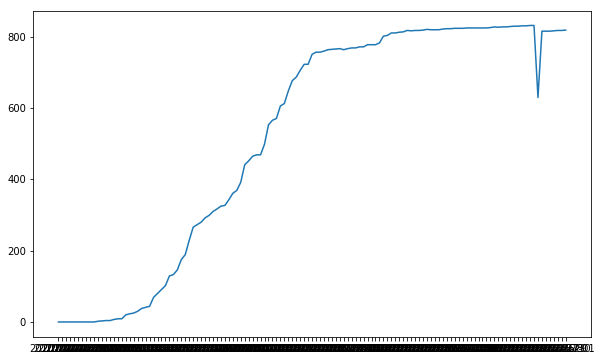

In [1009]:
plt.plot(italy_data_province_preds[italy_data_province_preds['Area name']=='Chieti']['hosp'])

In [1010]:
italy_data_all_areas = pd.concat([italy_data_national_preds, italy_data_regional_preds], axis = 0)

print("The dataset contains {} duplicates".format(italy_data_all_areas.duplicated().sum()))

italy_data_all_areas.drop_duplicates(inplace = True)

italy_data_all_areas.head()

The dataset contains 440 duplicates


,Area code,Area name,Area type,hosp
Specimen date,,,,
2020-02-24,None,ITALY,Nation,221
2020-02-25,None,ITALY,Nation,532
2020-02-26,None,ITALY,Nation,917
2020-02-27,None,ITALY,Nation,1505
2020-02-28,None,ITALY,Nation,2326


In [1026]:
italy_data_all_areas['Area name'] = italy_data_all_areas['Area name'].apply(lambda x : 'Bolzano' if x == 'P.A. Bolzano' else 'Trento' if x == 'P.A. Trento' else x)


In [1027]:
italy_data_all_areas['Area name'].unique()

array(['ITALY', 'Abruzzo', 'Basilicata', 'Calabria', 'Campania',
       'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria',
       'Lombardia', 'Marche', 'Molise', 'Bolzano', 'Trento', 'Piemonte',
       'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria',
       "Valle d'Aosta", 'Veneto'], dtype=object)

In [1028]:
## Before processing The Risk Index , proceed to some basic Regions names cleaning
## P.A. Bolzano = Bolzano and PA Trento = Trento

italy_data_all_areas['Area name'] = italy_data_all_areas['Area name'].apply(lambda x : 'Bolzano' if x == 'P.A. Bolzano' else 'Trento' if x == 'P.A. Trento' else x)

ita_all_areas_preds = pd.DataFrame()

area_types_all = italy_data_all_areas['Area type'].unique()

for area_type in area_types_all:
    
    df_area_type = italy_data_all_areas[italy_data_all_areas['Area type'] == area_type]
    
    ita_area_preds = pd.DataFrame()
    
    area_names_all = df_area_type['Area name'].unique()
    
    for area_name in area_names_all:
        
        print("Generating risk index for: {} - {}".format(area_type, area_name))
        
        one_preds = generate_predictions_granular(italy_data_all_areas, 'hosp', 6, 'ITALY', 'ITA', area_type, area_name)
        
        ita_area_preds = ita_area_preds.append(one_preds)
    
    ita_all_areas_preds = ita_all_areas_preds.append(ita_area_preds)
        
ita_all_areas_preds.head()      

Generating risk index for: Nation - ITALY
Predicting 6 Days ahead
Series Shape: (129, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Region - Abruzzo
Predicting 6 Days ahead
Series Shape: (112, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
----------------------------

Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Region - Puglia
Predicting 6 Days ahead
Series Shape: (109, 4)
Training KF and Predicting hosp, 6 days ahead
--------------------------------
Reading and merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Adding Geolocation Data
--------------------------------
Generating risk index for: Region - Sardegna
Predicting 6 Days ahead
Series Shape: (88, 4)
Training KF and 

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,risk_index,risk_index_disc,latitude,longitude
0,2020-03-07,8701.989882,8403.984959,8999.994805,225.069004,2777.928139,ITALY,ITALY,Nation,74.54,0.094,205.859,11325548.0,60461828.0,-19.0,1.0,2.0,-24.0,-15.0,0,100.0,90 - 100,42.638426,12.674297
1,2020-03-08,12181.240148,11914.469892,12448.010405,245.178771,3234.299911,ITALY,ITALY,Nation,74.54,0.130,205.859,11325548.0,60461828.0,-32.0,3.0,1.0,-27.0,-10.0,0,100.0,90 - 100,42.638426,12.674297
2,2020-03-09,16044.128451,15812.812931,16275.443971,264.661099,3716.391720,ITALY,ITALY,Nation,74.54,0.064,205.859,11325548.0,60461828.0,-30.0,-1.0,-24.0,-42.0,-24.0,0,100.0,90 - 100,42.638426,12.674297
3,2020-03-10,20145.360605,19942.747075,20347.974136,283.462814,4218.518854,ITALY,ITALY,Nation,82.41,0.115,205.859,11325548.0,60461828.0,-43.0,-2.0,-32.0,-51.0,-31.0,0,100.0,90 - 100,42.638426,12.674297
4,2020-03-11,24687.562306,24497.746372,24877.378241,304.027625,4773.851773,ITALY,ITALY,Nation,85.19,0.205,205.859,11325548.0,60461828.0,-52.0,-14.0,-32.0,-57.0,-37.0,0,100.0,90 - 100,42.638426,12.674297


In [1029]:
ita_all_areas_preds.tail()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,risk_index,risk_index_disc,latitude,longitude
117,2020-07-03,19295.475027,19240.214018,19350.736036,0.053353,5.076849,ITALY,Veneto,Region,38.89,NaN,205.859,11325548.0,60461828.0,NaN,NaN,NaN,NaN,NaN,0,56.024969,50 - 70,45.647666,11.866525
118,2020-07-04,19298.015303,19230.615587,19365.415018,0.037783,5.114632,ITALY,Veneto,Region,38.89,NaN,205.859,11325548.0,60461828.0,NaN,NaN,NaN,NaN,NaN,0,56.071506,50 - 70,45.647666,11.866525
119,2020-07-05,19300.569690,19219.091416,19382.047964,0.044731,5.159363,ITALY,Veneto,Region,38.89,NaN,205.859,11325548.0,60461828.0,NaN,NaN,NaN,NaN,NaN,0,56.126589,50 - 70,45.647666,11.866525
120,2020-07-06,19303.139797,19205.579877,19400.699717,0.056018,5.215382,ITALY,Veneto,Region,38.89,NaN,205.859,11325548.0,60461828.0,NaN,NaN,NaN,NaN,NaN,0,56.195548,50 - 70,45.647666,11.866525
121,2020-07-07,19305.727546,19190.030088,19421.425004,0.061370,5.276752,ITALY,Veneto,Region,38.89,NaN,205.859,11325548.0,60461828.0,NaN,NaN,NaN,NaN,NaN,0,56.271068,50 - 70,45.647666,11.866525


In [963]:
italy_data_all_areas[italy_data_all_areas['Area name'] == 'In fase di definizione/aggiornamento']

,Area code,Area name,Area type,hosp
Specimen date,,,,
2020-02-24,None,In fase di definizione/aggiornamento,Province,0
2020-02-25,None,In fase di definizione/aggiornamento,Province,5
2020-02-26,None,In fase di definizione/aggiornamento,Province,9
2020-02-26,None,In fase di definizione/aggiornamento,Province,21
2020-02-27,None,In fase di definizione/aggiornamento,Province,12
2020-02-27,None,In fase di definizione/aggiornamento,Province,13
2020-02-28,None,In fase di definizione/aggiornamento,Province,20
2020-02-28,None,In fase di definizione/aggiornamento,Province,42
2020-02-29,None,In fase di definizione/aggiornamento,Province,18


### Merging All results in final DataFrame

In [1030]:
# all_areas_uk_risk_index.reset_index(inplace = True)

# fr_all_areas_preds.reset_index(inplace = True)

risk_index_world = pd.concat([all_areas_uk_risk_index, fr_all_areas_preds, ita_all_areas_preds], axis = 0)

risk_index_world.shape

(28245, 24)

In [1031]:
risk_index_world.head()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,risk_index,risk_index_disc,latitude,longitude
0,2020-02-21,42.977050,0.0,345.730280,0.331448,5.363903,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,5.0,-1.0,10.0,-3.0,-15.0,100.0,57.073783,50 - 70,52.795479,-0.54024
1,2020-02-23,48.139664,0.0,307.719759,0.196085,4.329917,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,-1.0,-2.0,-5.0,3.0,-1.0,100.0,55.802806,50 - 70,52.795479,-0.54024
2,2020-02-24,48.747261,0.0,281.042132,0.059168,2.406793,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,-3.0,-1.0,-9.0,-2.0,-2.0,100.0,53.419818,50 - 70,52.795479,-0.54024
3,2020-02-25,43.565993,0.0,246.641714,-0.074462,1.251643,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,-1.0,4.0,3.0,1.0,1.0,100.0,51.980192,50 - 70,52.795479,-0.54024
4,2020-02-26,38.167354,0.0,220.883465,-0.066756,0.906198,ENGLAND,England,Nation,11.11,NaN,272.898,17831615.0,67886004.0,1.0,0.0,6.0,-1.0,1.0,100.0,51.548926,50 - 70,52.795479,-0.54024


In [1016]:
all_areas_uk_risk_index.shape

(14216, 24)

In [915]:
fr_all_areas_preds.shape

(11763, 24)

In [1032]:
ita_all_areas_preds.shape

(2266, 24)

(array([ 908.,  470.,  767., 1453., 7023., 8121., 3102., 2070., 1420.,
        2905.]),
 array([6.80895992e-27, 1.00000000e+01, 2.00000000e+01, 3.00000000e+01,
        4.00000000e+01, 5.00000000e+01, 6.00000000e+01, 7.00000000e+01,
        8.00000000e+01, 9.00000000e+01, 1.00000000e+02]),
 <a list of 10 Patch objects>)

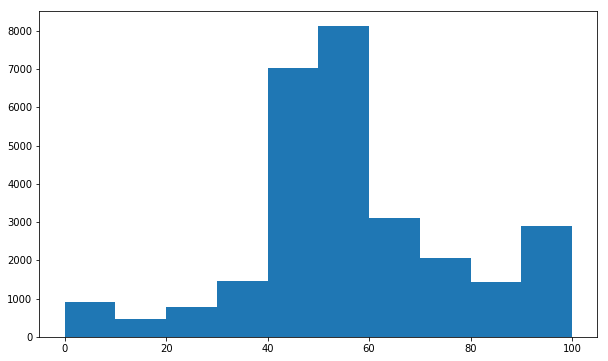

In [1018]:
plt.hist(risk_index_world[['risk_index']].to_numpy().flatten())

In [1033]:
## Write Data to CoS

from project_lib import Project

project = Project.access()

project.save_data(file_name = "risk_index_world.csv",data = risk_index_world.to_csv(index = False), overwrite = True)


{'file_name': 'risk_index_world.csv',
 'message': 'File saved to project storage.',
 'asset_id': 'e87f9f71-feab-491a-a289-c38459658d8e'}